In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re
import optuna

/home/thomasdev/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Catch errors immediately

import torch
torch.cuda.empty_cache()

In [3]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    hsic_loss
    )

In [ ]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    plot_distance_over_time,
    ensemble_autoregressive_prediction_gaussian_mixture_simple,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    test_model_variance_in_all_trajectories_in_df,
    plot_prediction_losses,
    plot_variance_losses,
    test_model_with_varying_observed_points,
    test_model_variance_with_varying_observed_points,
    test_model_variance_with_varying_observed_points_multiple_periods,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    test_model_in_all_trajectories_with_different_single_observation_in_df,
    plot_all_transformed_trajectories, 
    plot_all_transformed_trajectories_multiple_periods,
    plot_transformed_trajectory,
    test_model_energy_in_single_trajectory,
    get_top_checkpoint_epochs,
    evaluate_all_checkpoints
    )

In [5]:
save_dir_path = "./save_directory_noisy_full_pred_low_samples_4" 


In [6]:
with open("all_dataframes_low_samples.pkl", "rb") as f:
    loaded_dfs_low_samples = pickle.load(f)

# Access them like before:
train_df_low_samples = loaded_dfs_low_samples['train_df_low_samples']
val_df_low_samples = loaded_dfs_low_samples['val_df_low_samples']
test_df_low_samples = loaded_dfs_low_samples['test_df_low_samples']

train_id_df_low_samples = loaded_dfs_low_samples['train_id_df_low_samples']
val_id_df_low_samples = loaded_dfs_low_samples['val_id_df_low_samples']
test_id_df_low_samples = loaded_dfs_low_samples['test_id_df_low_samples']

with open("df_high_energy_low_samples.pkl", "rb") as f:
    df_high_energy_low_samples = pickle.load(f)

val_df_high_energy_low_samples = df_high_energy_low_samples['val_df_high_energy_low_samples']
val_id_df_high_energy_low_samples = df_high_energy_low_samples['val_id_df_high_energy_low_samples']

test_df_high_energy_low_samples = df_high_energy_low_samples['test_df_high_energy_low_samples']
test_id_df_high_energy_low_samples = df_high_energy_low_samples['test_id_df_high_energy_low_samples']

with open("all_dataframes_low_samples_multiple_periods.pkl", "rb") as f:
    df_low_samples_multiple_periods = pickle.load(f)

test_df_low_samples_multiple_periods = df_low_samples_multiple_periods['data_df_low_samples_multiple_periods']
test_id_df_low_samples_multiple_periods = df_low_samples_multiple_periods['id_df_low_samples_multiple_periods']


with open("all_dataframes_test_traj.pkl", "rb") as f:
    dfs_test_traj = pickle.load(f)

test_df_test_traj = dfs_test_traj['data_df_test_traj']
test_id_df_test_traj = dfs_test_traj['id_df_test_traj']

In [7]:
train_id_df_low_samples_added = add_phi_A_columns(train_id_df_low_samples)
val_id_df_low_samples_added = add_phi_A_columns(val_id_df_low_samples)
val_id_df_high_energy_low_samples_added = add_phi_A_columns(val_id_df_high_energy_low_samples)
test_id_df_low_samples_added = add_phi_A_columns(test_id_df_low_samples)
test_id_df_low_samples_multiple_periods_added = add_phi_A_columns(test_id_df_low_samples_multiple_periods)
test_id_df_high_energy_low_samples_added = add_phi_A_columns(test_id_df_high_energy_low_samples)
test_id_df_test_traj_added = add_phi_A_columns(test_id_df_test_traj)



📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 507 with the value: 0.0410, the losses of the last 5 epochs are: ['0.0589', '0.1045', '0.0519', '0.0796', '0.0410']
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 507 with the value: 0.0009, the losses of the last 5 epochs are: ['0.0025', '0.0046', '0.0018', '0.0022', '0.0009']
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 442 with the value: 0.0390, the losses of the last 5 epochs are: ['0.0619', '0.0987', '0.0471', '0.0716', '0.0406']
  Lowest loss of metric 'val_variance_loss_' recorded in epoch 507 with the value: 0.0014, the losses of the last 5 epochs are: ['0.0024', '0.0049', '0.0024', '0.0030', '0.0014']
  Lowest loss of metric 'train_total_loss_' recorded in epoch 460 with the value: 0.5660, the losses of the last 5 epochs are: ['0.5911', '0.5998', '0.5900', '0.5997', '0.5967']
  Lowest loss of metric 'train_hsic_loss_' recorded in ep

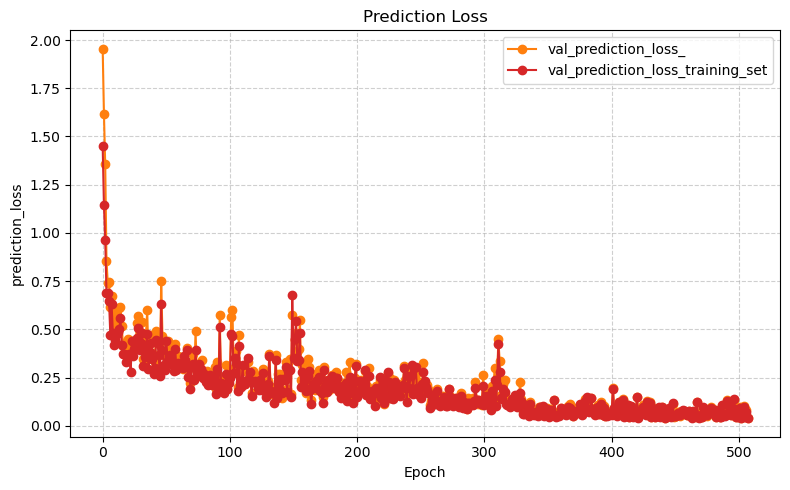

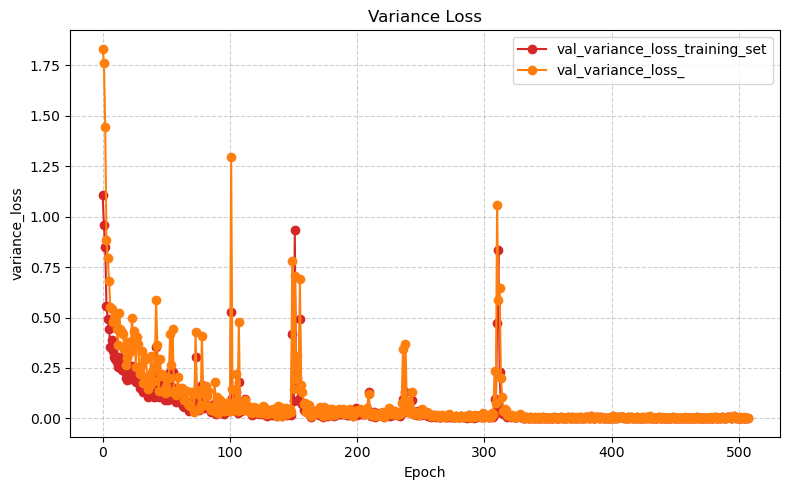

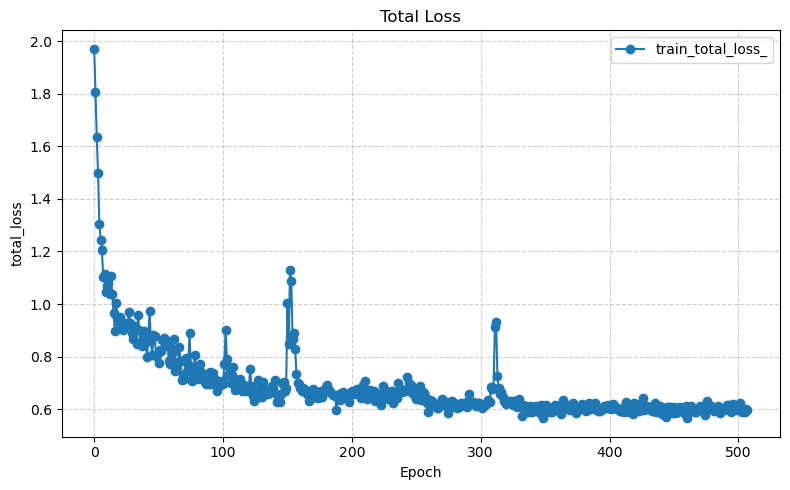

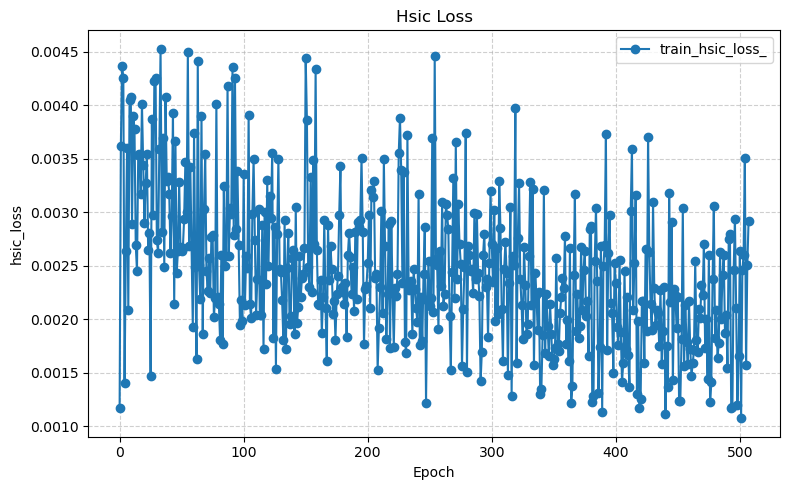

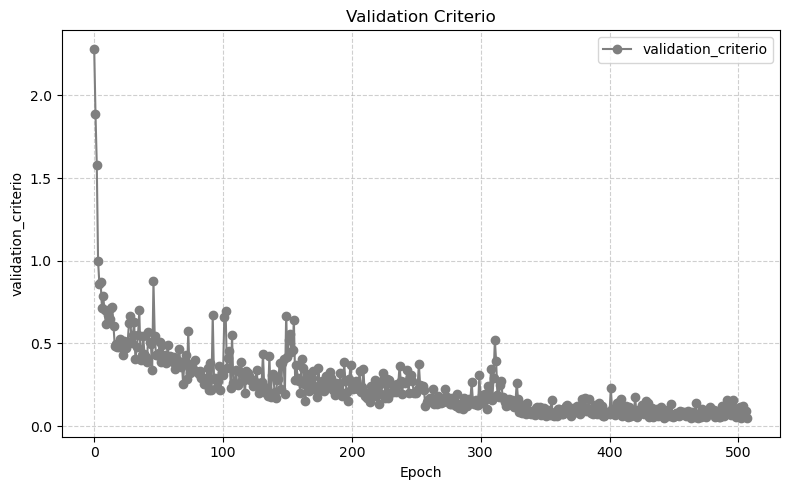

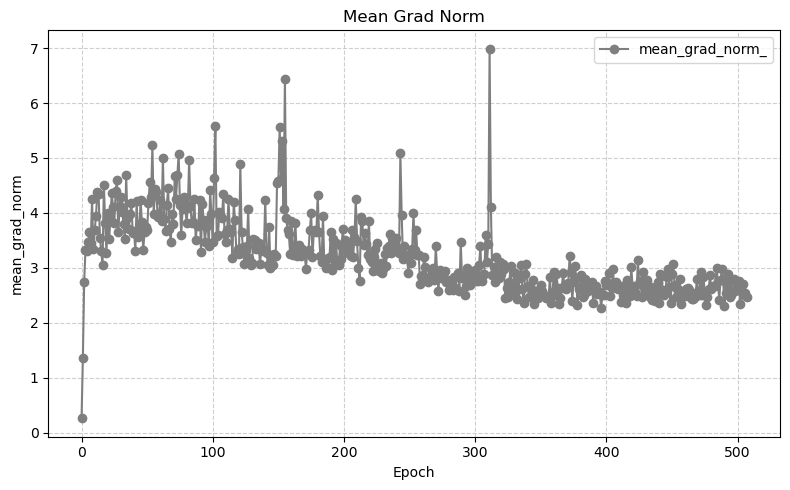

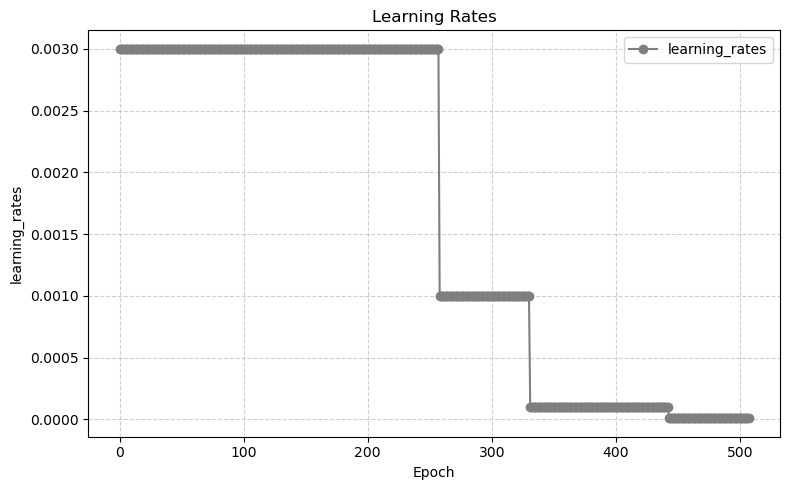

In [40]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "val_variance_loss_training_set", "val_prediction_loss_training_set",  "val_variance_loss_", "train_total_loss_", "train_hsic_loss_" , "validation_criterio", "mean_grad_norm_", "learning_rates"],
plot_on_same_graph=True,
verbose=True,
specific_epochs=None
)




📊 Processing directory: val_trajectories_data

For the epoch_507 in val_trajectories_data the values are:
58: X_mean = 3.0980 ± 0.0243, U_mean = -1.8570 ± 0.0346 and A=1.2861003281447578, phi=3.10971502940812
60: X_mean = 1.3722 ± 0.0196, U_mean = -0.6767 ± 0.0194 and A=1.302803629599372, phi=0.3584896193449746
31: X_mean = 0.9509 ± 0.0235, U_mean = -2.1955 ± 0.0247 and A=1.034538675096427, phi=-1.0225411941027112

📊 Processing directory: val_train_set_trajectories_data

For the epoch_507 in val_train_set_trajectories_data the values are:
26: X_mean = 1.2259 ± 0.0116, U_mean = -1.3000 ± 0.0171 and A=0.9808986503009178, phi=-0.10350682800806513
51: X_mean = 0.7063 ± 0.0254, U_mean = -2.2377 ± 0.0301 and A=1.225847748581651, phi=-0.9160542480716283
20: X_mean = 1.6858 ± 0.0353, U_mean = -2.3818 ± 0.0178 and A=0.9123773519944653, phi=-1.9937946817401142

📊 Processing directory: val_high_energy_trajectories_data
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_0/val_high_

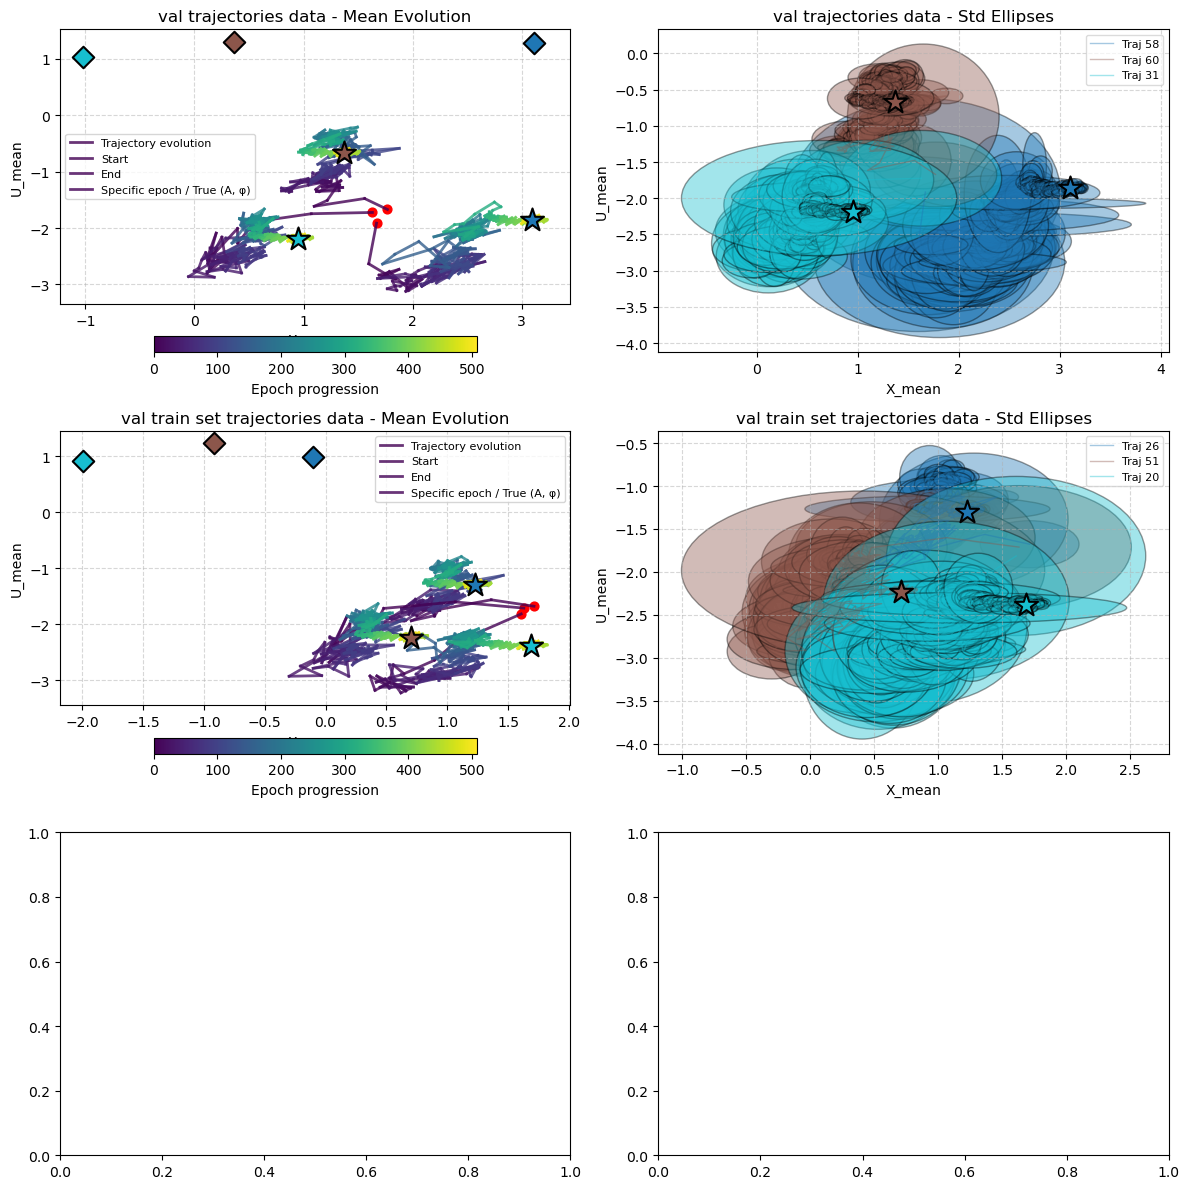


✅ Mean + Std (ellipse) visualization complete.


In [13]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_low_samples_added,val_id_df_added=val_id_df_low_samples_added,val_id_df_high_energy_added=val_id_df_high_energy_low_samples_added)

In [14]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch="last",
    train_id_df_added=train_id_df_low_samples_added,
    val_id_df_added=val_id_df_low_samples_added,
    val_id_df_high_energy_added=val_id_df_high_energy_low_samples_added
)

📂 Using data from epoch: epoch_507
⚠️ Warning: ./save_directory_noisy_full_pred_low_samples_4/epoch_507/val_high_energy_trajectories_data not found.
✅ Data extraction complete.


In [15]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['A']),
    y=torch.Tensor(val_train_differencies_set_df['phi']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.0025)

In [16]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.0018)

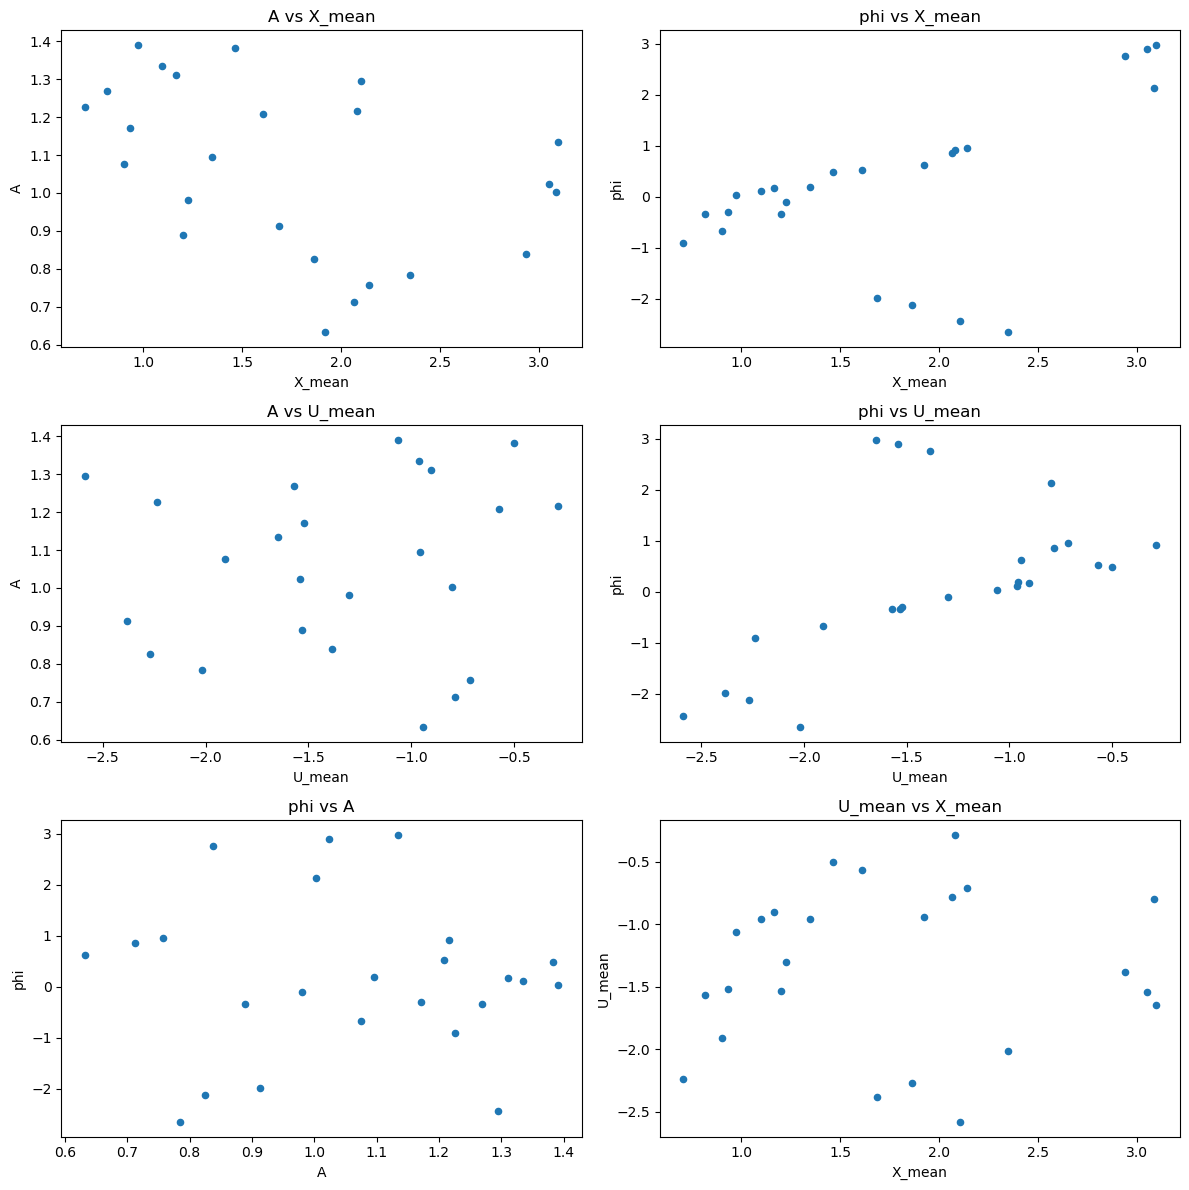

In [17]:
plot_differencies(val_train_differencies_set_df)

📊 Analyzing 508 epochs across 3 directories...

📁 Processing directory: val_trajectories_data

📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_0/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_1/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_2/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_3/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_4/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_4/epoch_5/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./s

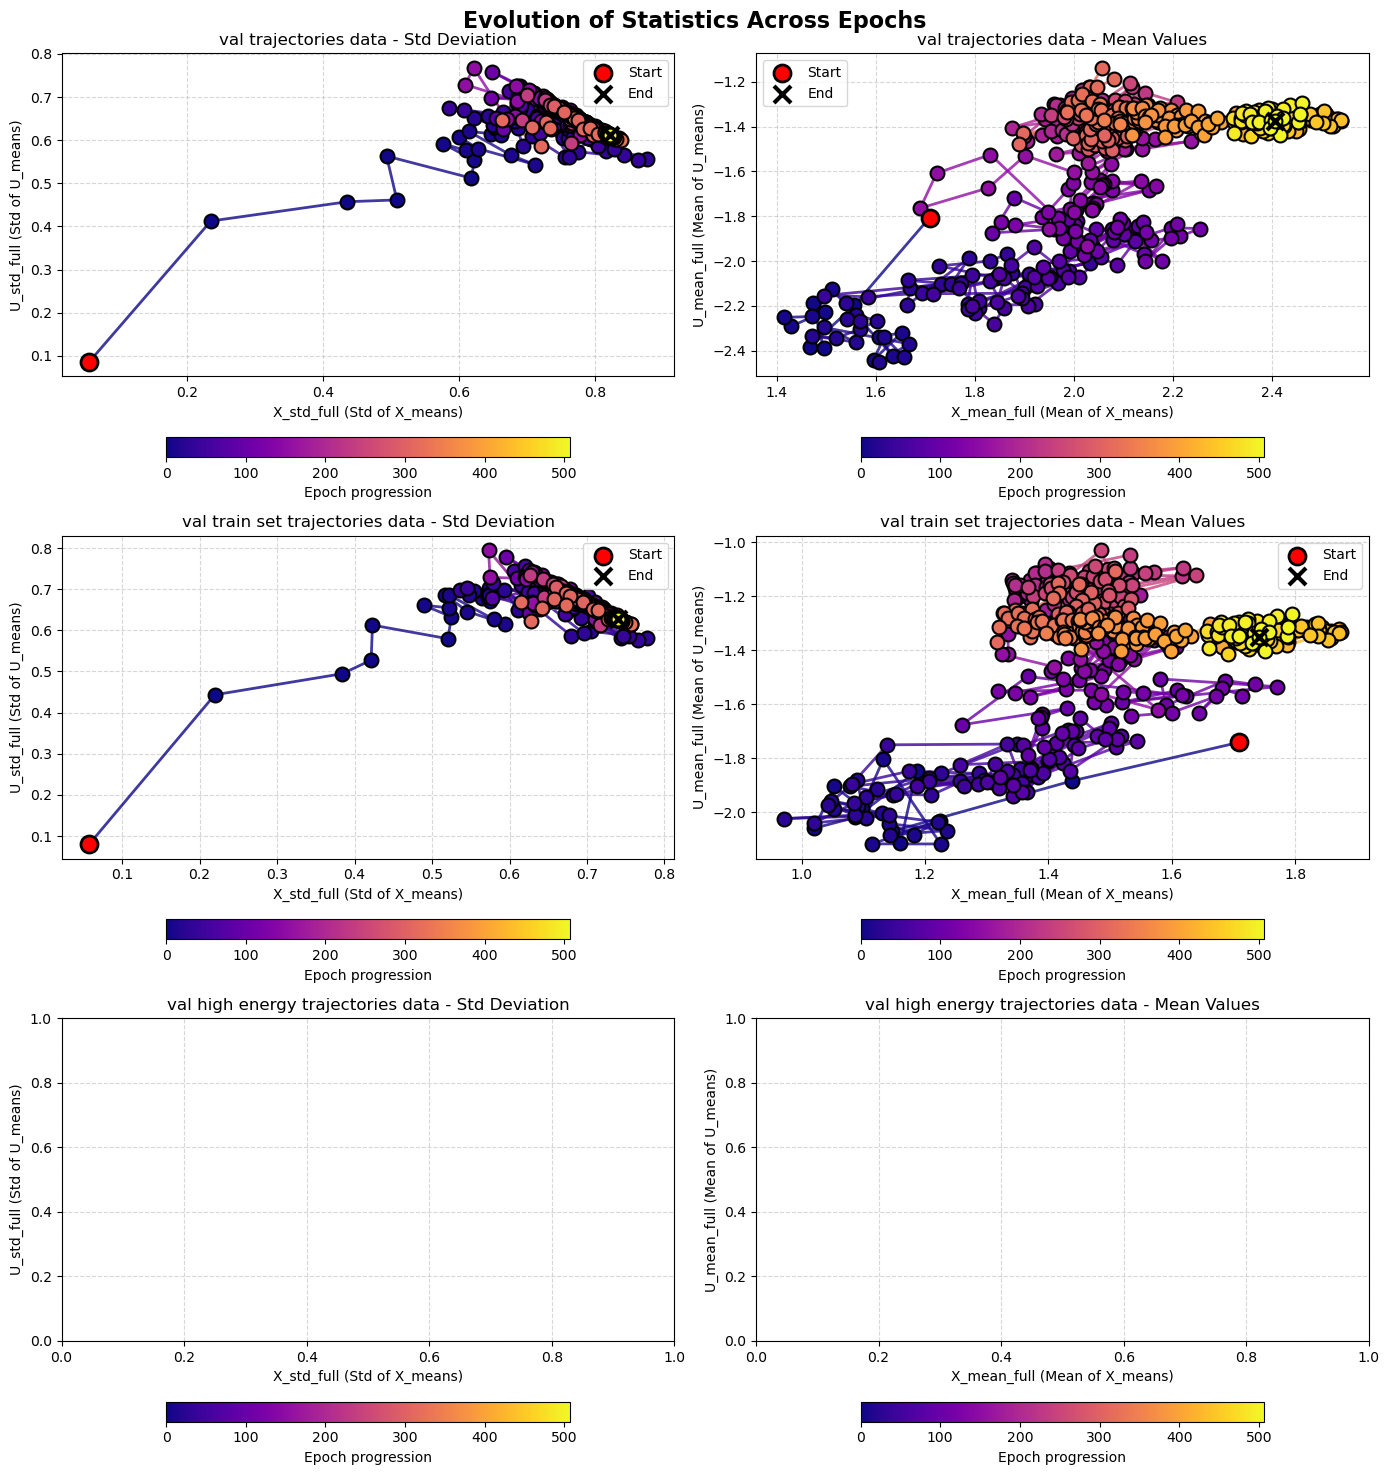

In [18]:
analyze_folders_means(save_dir_path, locate_epoch=None)

In [8]:
point_indexes_observed = [0]

In [9]:
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
print(f"Period is constant and = {period:.3f}")

tmax_list = []
for idx, row in train_id_df_low_samples.iterrows():
    trajectory_id = int(row['trajectory_id'])
    start_index = int(row['start_index'])
    end_index = int(row['end_index'])
    
    test_trajectory_data = get_data_from_trajectory_id(train_id_df_low_samples, train_df_low_samples, trajectory_ids=trajectory_id)
    t = test_trajectory_data['t'].to_numpy(dtype=np.float32)
    tmax = max(t)
    tmax_list.append(tmax)
max_t_training = min(np.array(tmax_list))
dt = (t[1]-t[0]).item()

    

Period is constant and = 6.283


In [10]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [33, 60, 32],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

In [11]:


checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:7003: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [23]:
test_canonical_tranformation_on_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, compute_jacobian_functional_function=compute_jacobian_functional, compute_symplectic_product_function=compute_symplectic_product, check_canonical_transformation_function=check_canonical_transformation, tolerance=1e-4, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, trajectory_id=57, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

For the mapping network:
✓ All 32 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 3.58e-07
For the inverse network:
✓ All 32 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 4.77e-07


In [24]:
print(f"Number of parameters are: {count_parameters(mapping_net)}, with number of training samples: {train_df_low_samples.shape[0]}\nThat is a ratio of parameters/samples of: {count_parameters(mapping_net)/train_df_low_samples.shape[0]}")

Number of parameters are: 82560, with number of training samples: 768
That is a ratio of parameters/samples of: 107.5


   num_observed_points  mean_loss
0                    1   0.035835
1                    2   0.032744
2                    3   0.030298
3                    4   0.029975
4                    5   0.027175
5                    6   0.026146
6                    7   0.025591
7                    8   0.024965
8                    9   0.022161
9                   10   0.021057


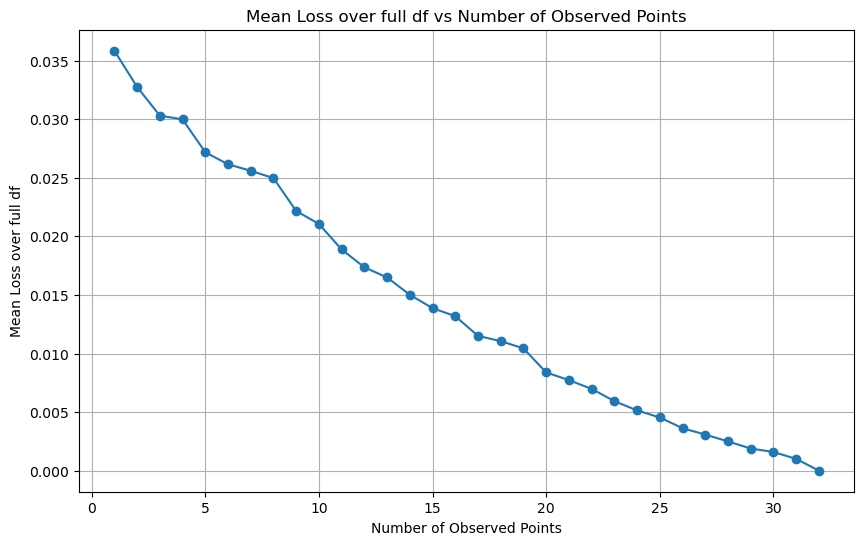

In [25]:
val_loss_per_points_df = test_model_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.002139
2                    3       0.004073
3                    4       0.003059
4                    5       0.003735
5                    6       0.003223
6                    7       0.002968
7                    8       0.002698
8                    9       0.002405
9                   10       0.002263


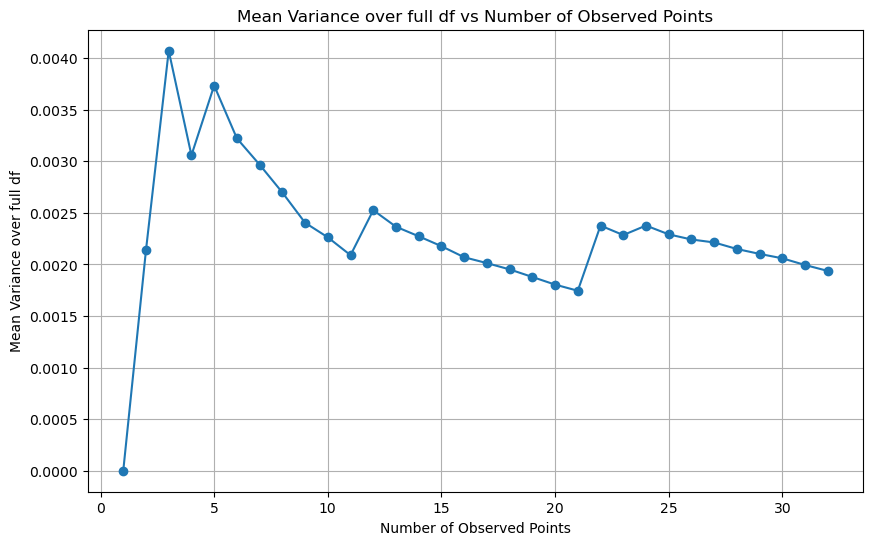

In [12]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id ,test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net ,device=device)

In [12]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "prediction_loss_function": prediction_loss_euclidean,
    "test_id_df": val_id_df_low_samples,
    "test_df": val_df_low_samples,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "recreate_and_plot_phase_space": False,
    "plot_specific_portion": 0.26,
    "connect_points": False,
    "plot_trajectories_subsample": 0.4,
    "max_t_training": max_t_training,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    
    # A. Suggest the Boolean switch first
    efficiently_param = trial.suggest_categorical("efficiently", [True, False])
    
    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False
    if efficiently_param:
        # If efficient, passed params don't matter, but we must pass something to avoid errors
        threshold_param = 1.0 
        upper_pct_param = 0.6 
    else:
        # If NOT efficient, Optuna suggests values within your specified ranges
        # suggest_float(name, low, high)
        threshold_param = trial.suggest_float("threshold", 0.1, 3.0) 
        upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.2, 0.9)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        _, mean_loss = test_model_in_all_trajectories_in_df(
            efficiently=efficiently_param,
            threshold=threshold_param,
            search_range_upper_pct=upper_pct_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=30, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 21. Best value: 0.0129796: 100%|██████████| 30/30 [18:40<00:00, 37.35s/it]

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.01297959165647626
Best Hyperparameters: {'efficiently': False, 'threshold': 0.11173971986688458, 'search_range_upper_pct': 0.20401416691119795}


In [13]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "prediction_loss_function": prediction_loss_euclidean,
    "test_id_df": val_id_df_low_samples,
    "test_df": val_df_low_samples,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "recreate_and_plot_phase_space": False,
    "plot_specific_portion": 0.26,
    "connect_points": False,
    "plot_trajectories_subsample": 0.4,
    "max_t_training": max_t_training,
    "efficiently": False,
    "method": "gaussian_mixture_simple",
    "threshold": 1.0,
    "dt": dt,
    "alpha":1.0,
    "gamma":1.0,
    "cluster_weight_threshold": 0.4,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    

    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False

        
    # suggest_float(name, low, high)

    search_range_upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.3, 0.7) 
    max_n_components_param = trial.suggest_int("max_n_components", 2, 5)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        _, mean_loss = test_model_in_all_trajectories_in_df(
            search_range_upper_pct = search_range_upper_pct_param,
            max_n_components = max_n_components_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=20, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 11. Best value: 0.0127305: 100%|██████████| 20/20 [1:33:15<00:00, 279.79s/it]

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.012730459198355675
Best Hyperparameters: {'search_range_upper_pct': 0.33924736848369563, 'max_n_components': 2}


------------------------------
BEST RESULTS FOUND:

Best Mean Loss: 0.011795881241559981
Best Hyperparameters: {'search_range_upper_pct': 0.4272842927260936, 'max_n_components': 2}

0.0267

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  0.221622         0.025502              0.054172
6               6  0.264865         0.020065              0.038987
9               9  0.297297         0.018741              0.034371
12             12  0.329730         0.019553              0.034051
15             15  0.362162         0.022254              0.036980
17             17  0.383784         0.022126              0.035715
21             21  0.427027         0.021647              0.033126
24             24  0.459459         0.023047              0.034002
25             25  0.470270         0.036800              0.053662
29             29  0.513514         0.026171              0.036520
33             33  0.556757         0.030513              0.040894
36             36  0.589189         0.031263              0.040729
39             39  0.621622         0.029971              0.038013
40             40  0.632432         0.029270              0.03

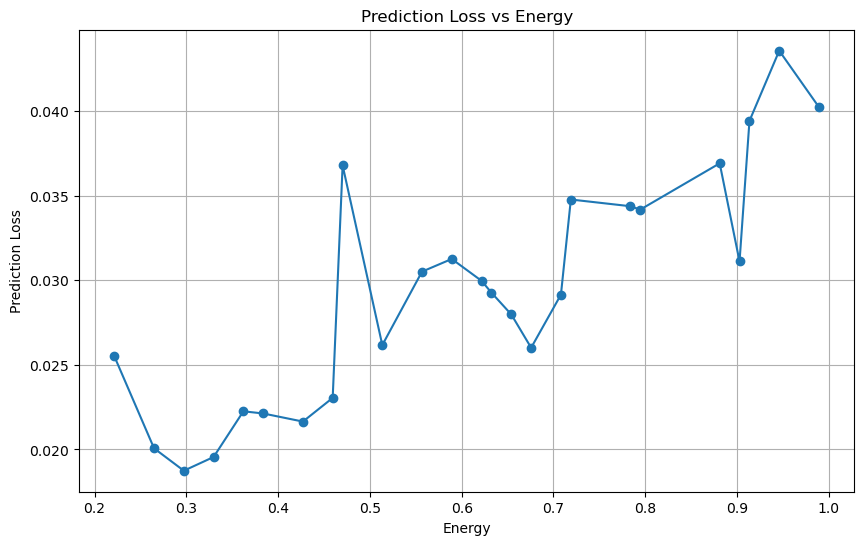

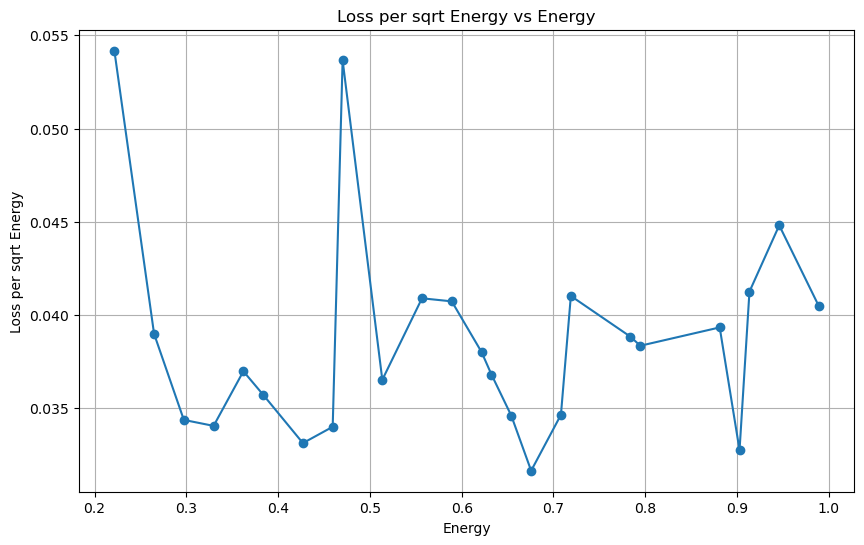

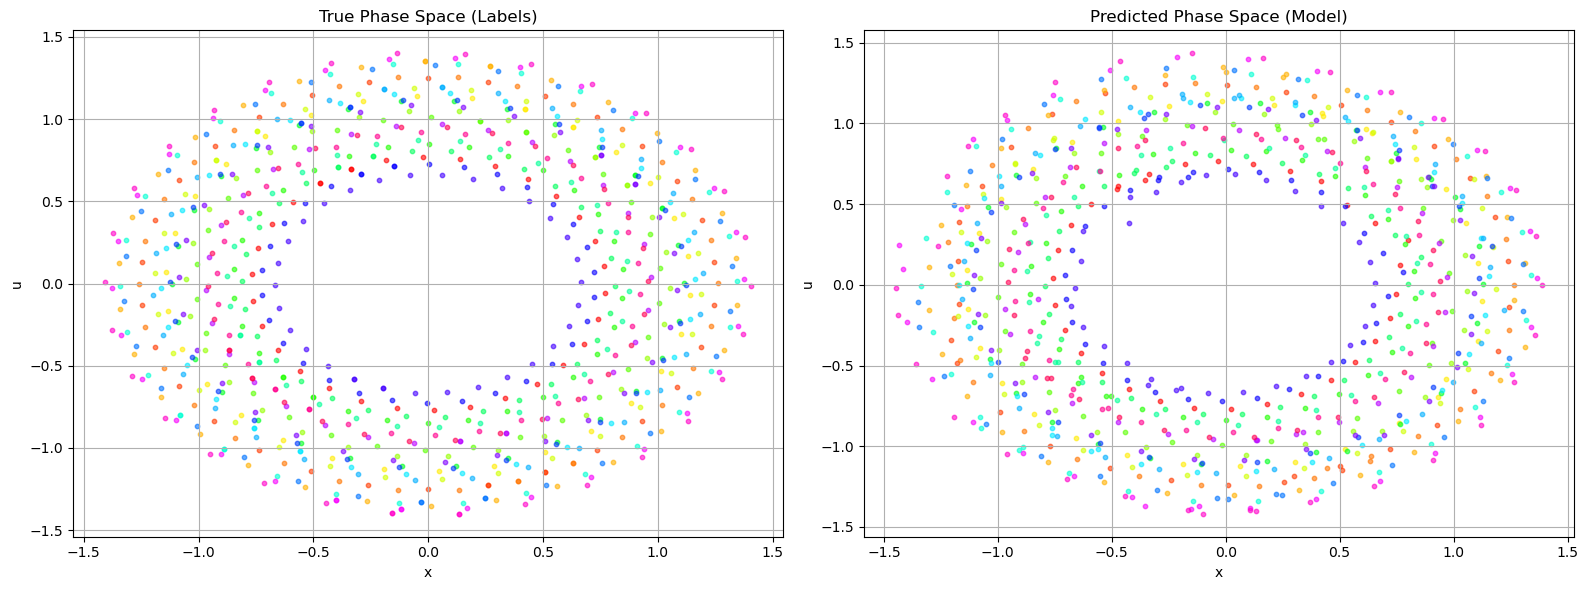

In [14]:
prediction_test_df, mean_prediction_loss_test, pred_test_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=1.0, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  0.221622         0.012622              0.026811
6               6  0.264865         0.012596              0.024475
9               9  0.297297         0.013971              0.025623
12             12  0.329730         0.013843              0.024107
15             15  0.362162         0.009544              0.015859
17             17  0.383784         0.015791              0.025490
21             21  0.427027         0.014839              0.022708
24             24  0.459459         0.020595              0.030384
25             25  0.470270         0.012061              0.017587
29             29  0.513514         0.011934              0.016654
33             33  0.556757         0.008741              0.011715
36             36  0.589189         0.009907              0.012906
39             39  0.621622         0.011477              0.014557
40             40  0.632432         0.014709              0.01

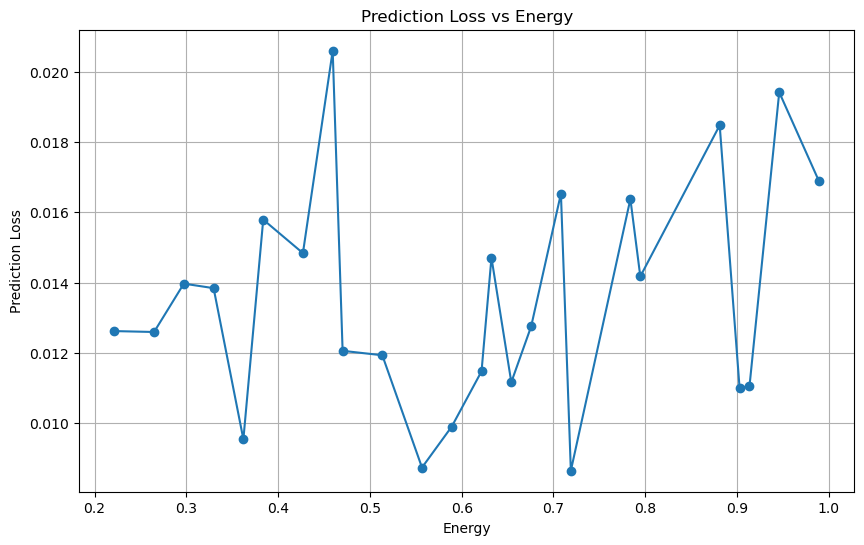

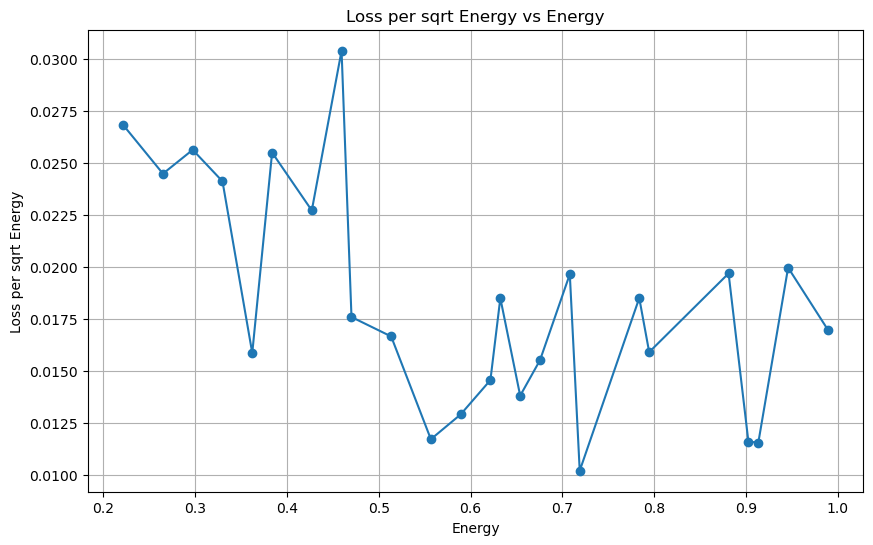

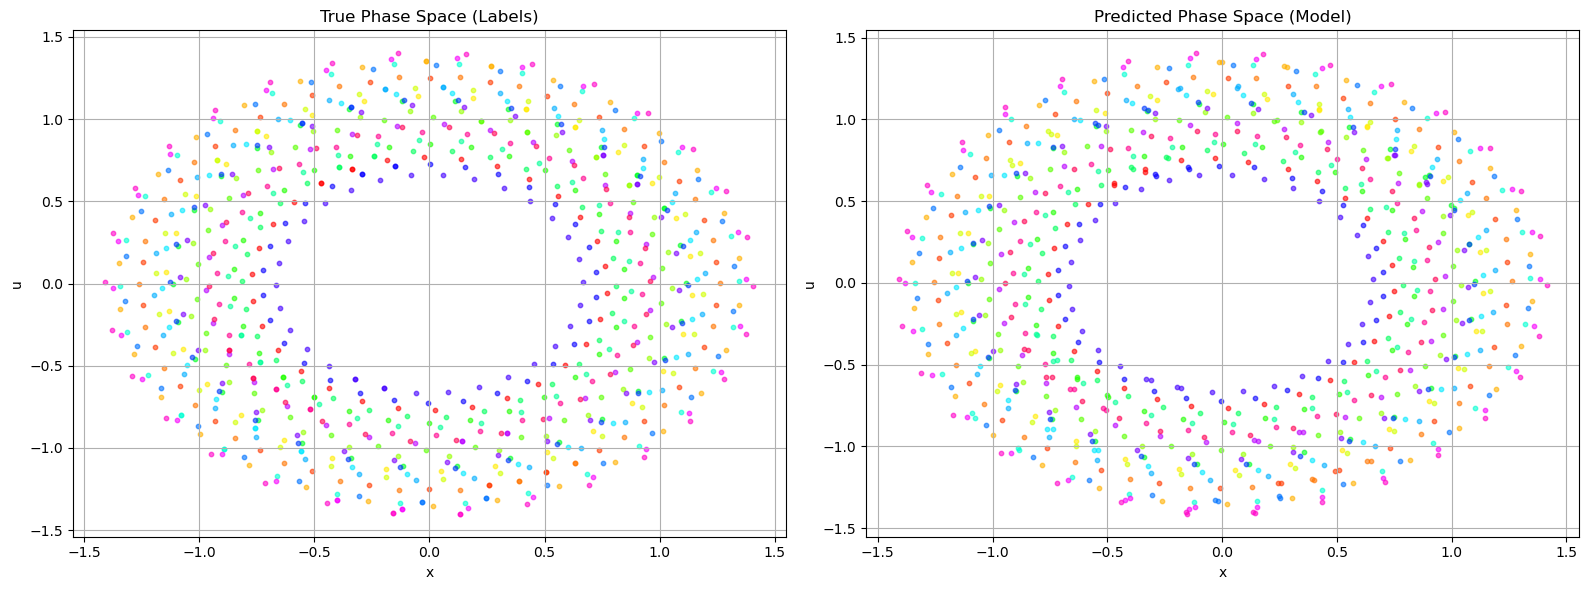

In [12]:
prediction_test_ensemble_df, mean_prediction_loss_test_ensemble, pred_test_ensemble_df = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True)

/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:11277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


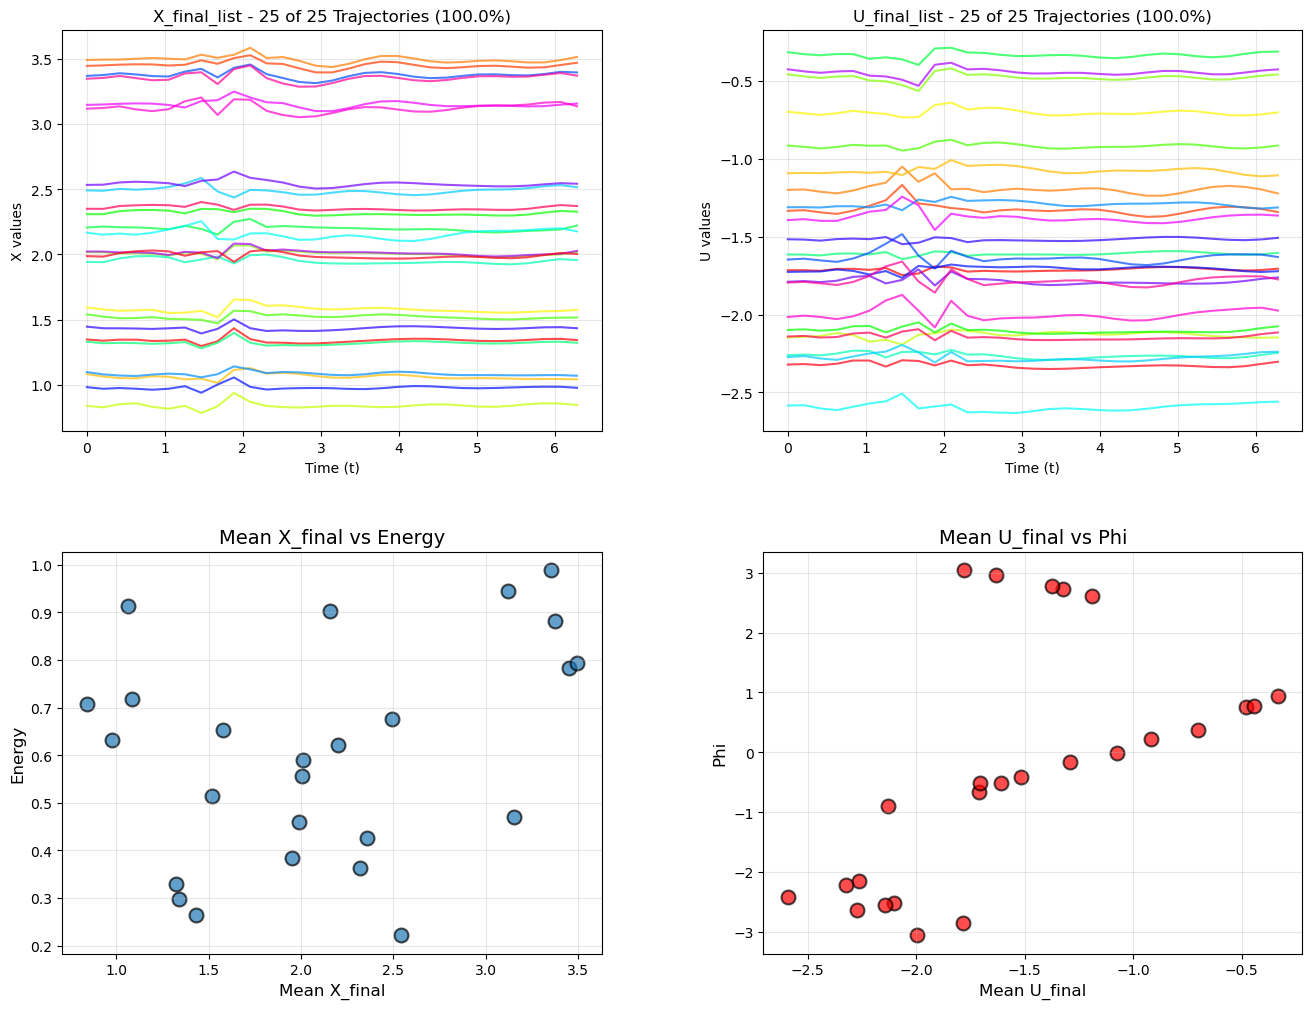

In [15]:
plot_all_transformed_trajectories(
    test_id_df_low_samples, 
    test_df_low_samples, 
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=False,
    only_plot_percentage=1.0
)

In [15]:
trajectory_id_test = 44
trajectory_id_test_ensemble = 44


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


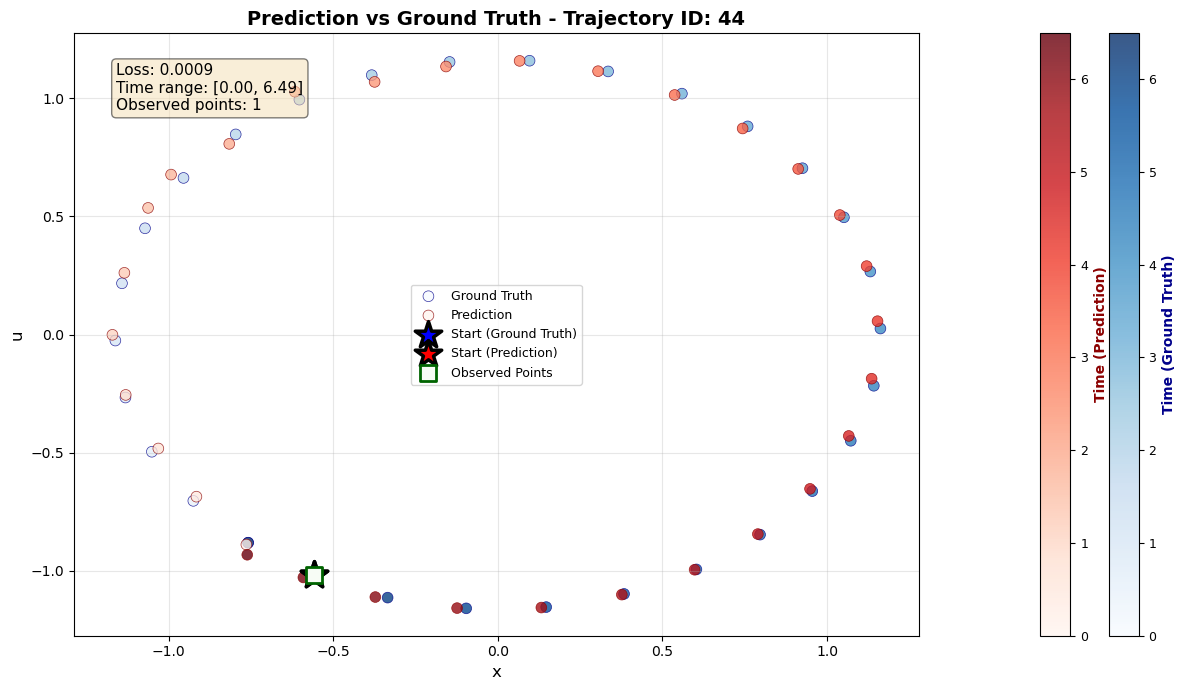

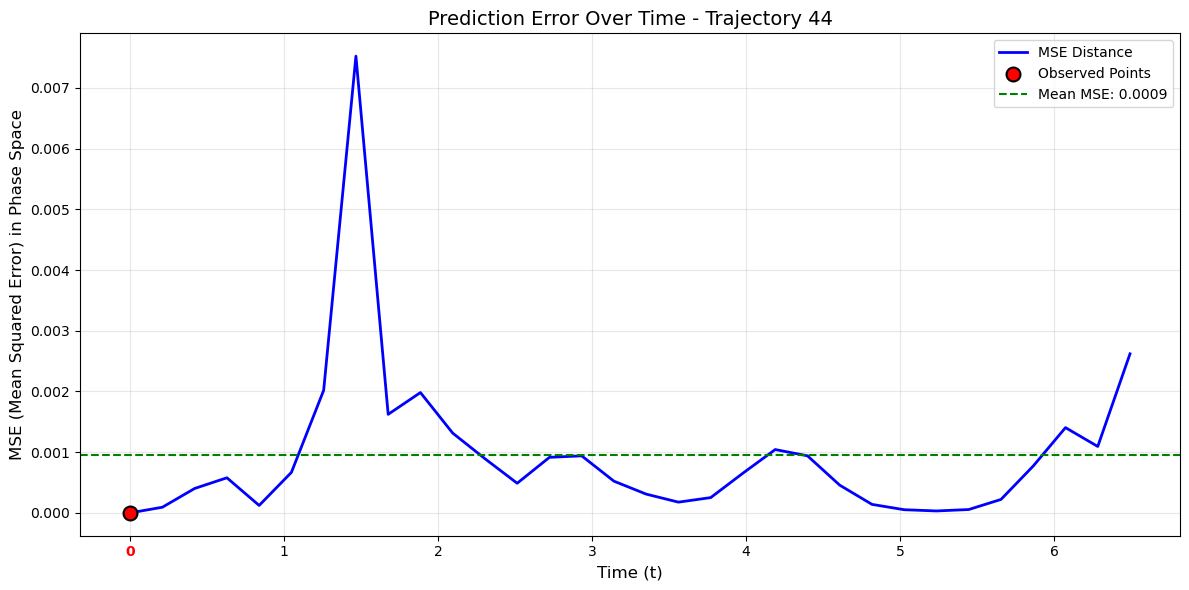

In [19]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, trajectory_id=trajectory_id_test, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=False, period=period, max_t_training=max_t_training, efficiently=True, method="mahalanobis", threshold=1.0, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=4, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True, plot=True)

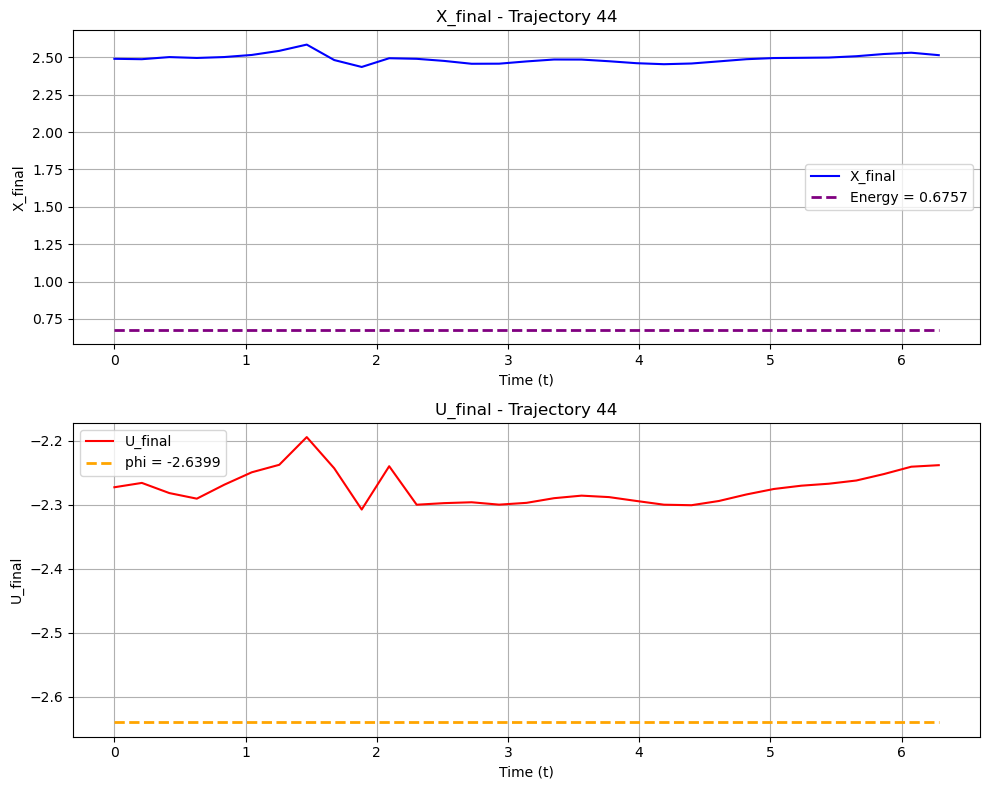

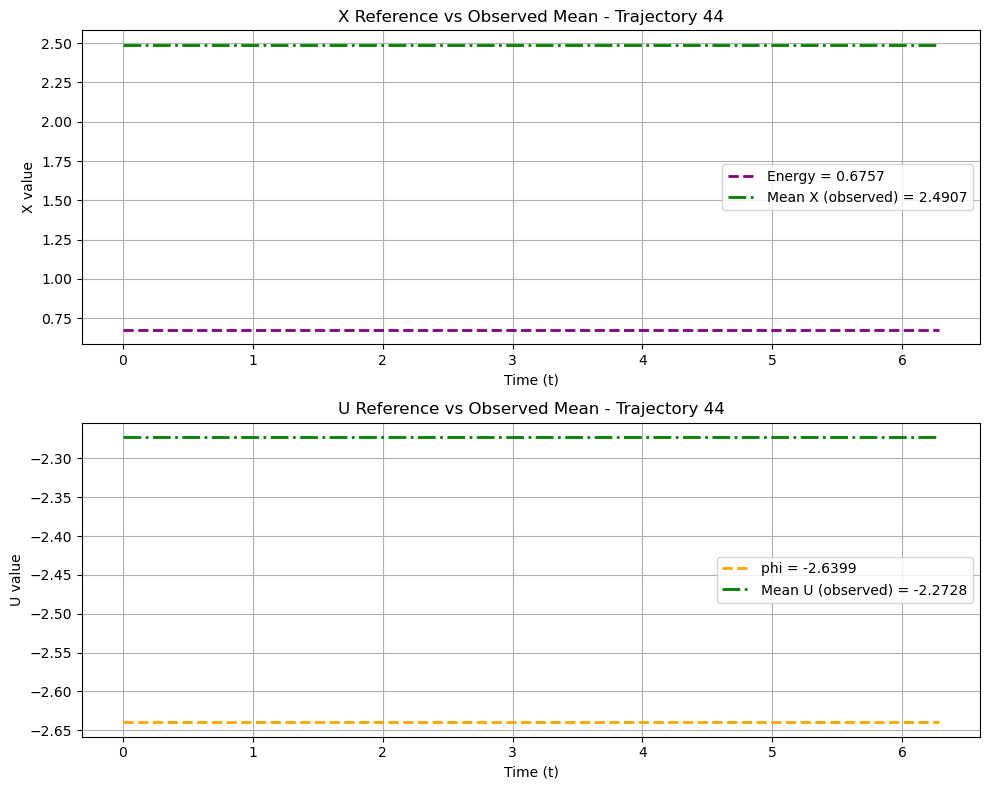

In [20]:
plot_transformed_trajectory(test_id_df_low_samples_added, test_df_low_samples, trajectory_id_test, 
                                get_data_from_trajectory_id, mapping_net,
                                max_t_training, device, option_1=False,
                                point_indexes_observed=point_indexes_observed)

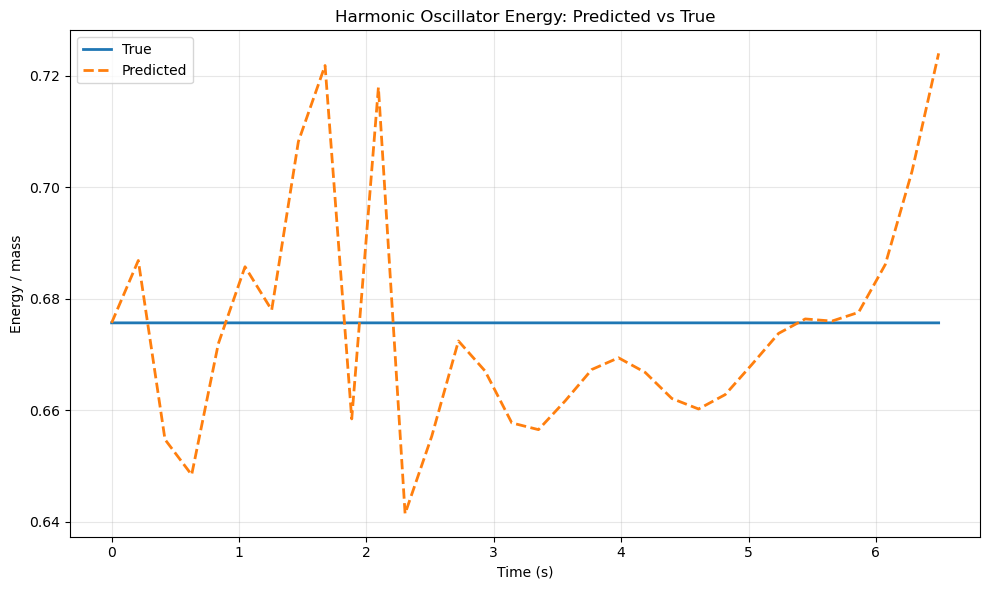

In [21]:
test_model_energy_in_single_trajectory(
    get_data_from_trajectory_id, 
    test_id_df_low_samples_added, 
    test_df_low_samples, 
    trajectory_id_test, 
    mapping_net, 
    inverse_net, 
    device, 
    point_indexes_observed, 
    max_t_training,
    efficiently=True,
    method = "mahalanobis",
    threshold=1.0,
    dt=0.1,
    alpha=1.0,
    gamma=1.0,
    cluster_weight_threshold=0.4,
    max_n_components=5,
    search_range_lower_pct=0.5,
    search_range_upper_pct=0.6,
    case="harmonic_oscillator",
    length=3.0, k=1, mass=1, g=9.81, constant=2.4,
    verbose=False,
    )


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 94
Total forward passes: 97
Coverage: 100.0%
Observed time points: [0.]


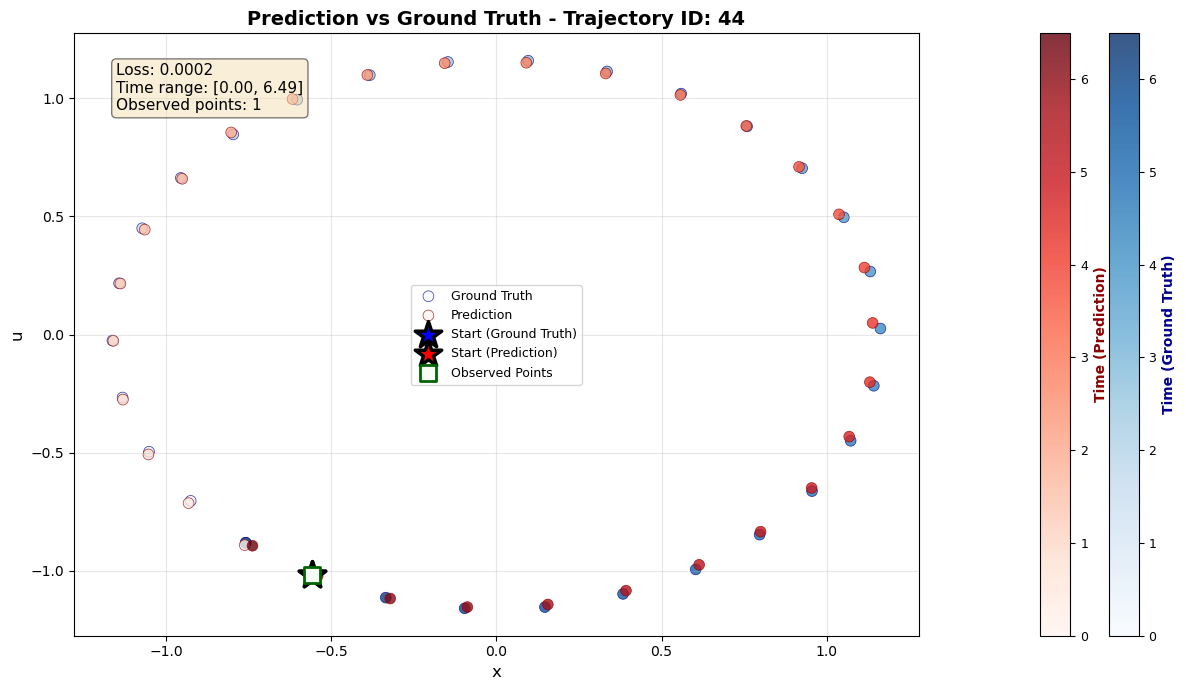

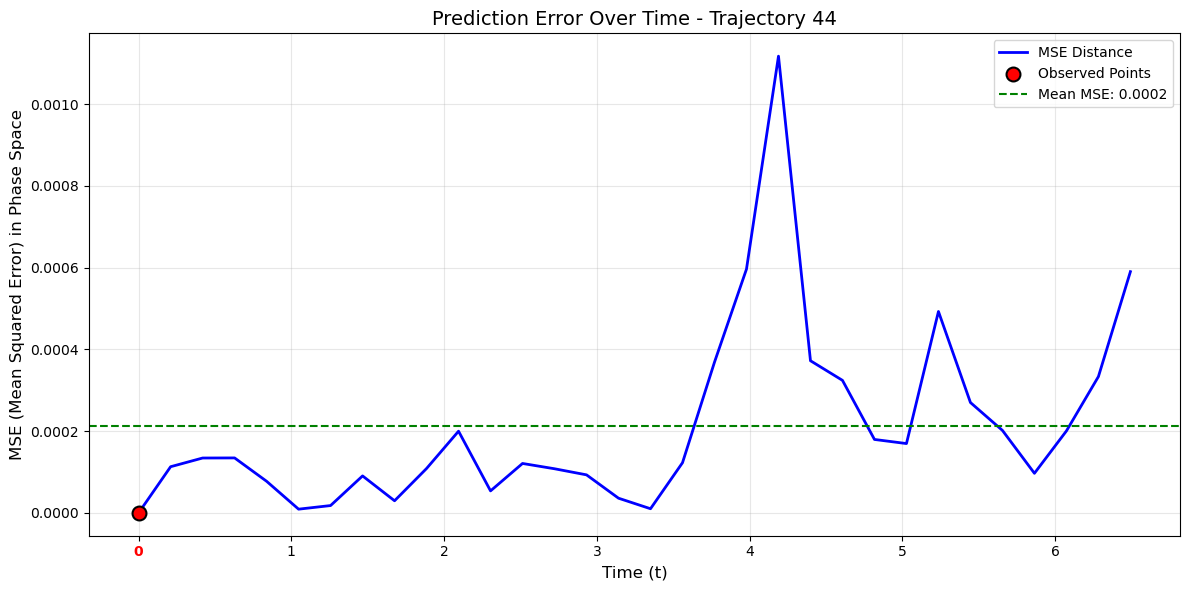

In [16]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_low_samples, 
test_df=test_df_low_samples, 
trajectory_id=trajectory_id_test_ensemble, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=None, 
show_zeroings=False, 
show_period=False, 
period=period, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True,
plot=True)

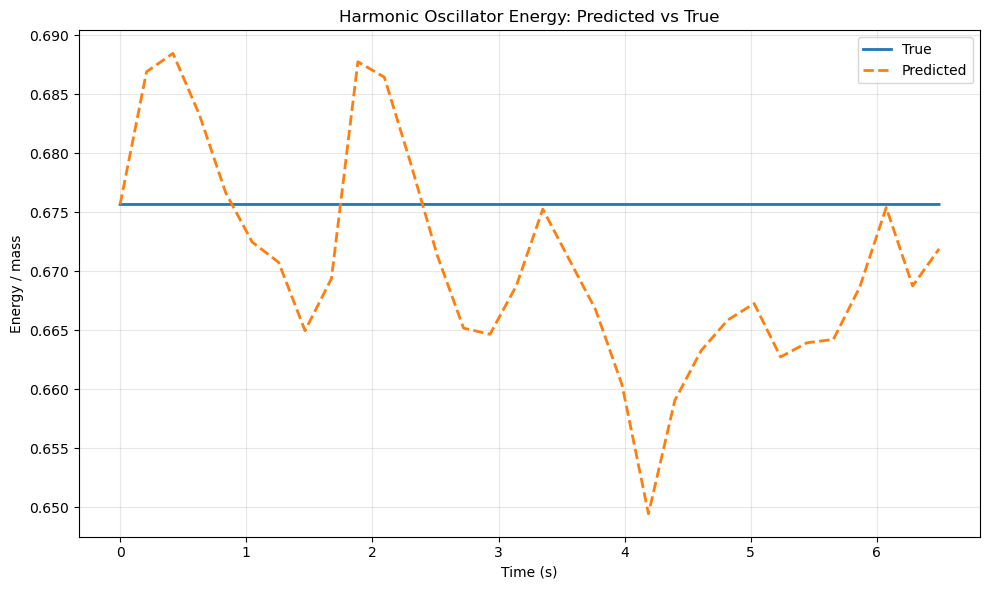

In [17]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id, 
test_id_df_low_samples_added, 
test_df_low_samples, 
trajectory_id_test_ensemble, 
mapping_net, 
inverse_net, 
device, 
point_indexes_observed, 
max_t_training,
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
case="harmonic_oscillator",
length=3.0, k=1, mass=1, g=9.81, constant=2.4,
verbose=False,
)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.000821
2                    3       0.000411
3                    4       0.000445
4                    5       0.000799
5                    6       0.000533
6                    7       0.000482
7                    8       0.000361
8                    9       0.000748
9                   10       0.000720


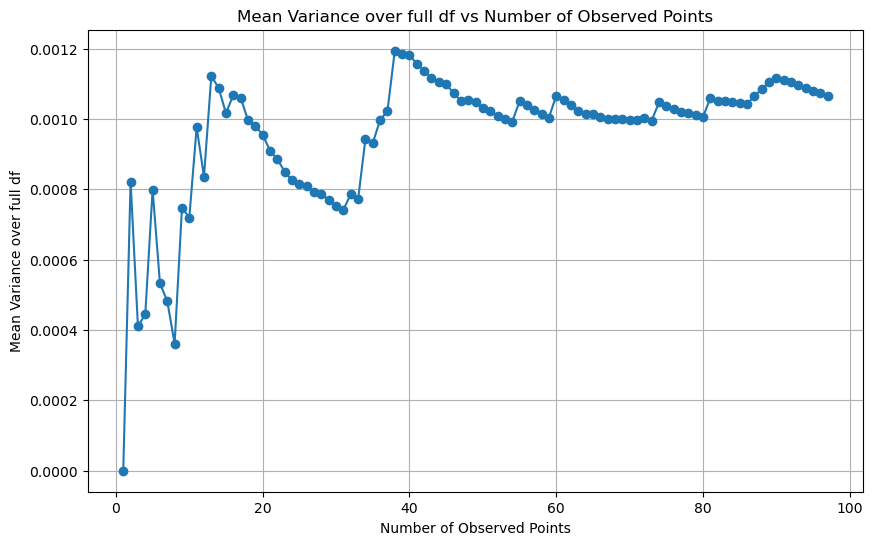

In [73]:
variance_with_varying_observed_points_multiple_periods_df = test_model_variance_with_varying_observed_points_multiple_periods(
get_data_from_trajectory_id,
test_id_df_low_samples_multiple_periods,
test_df_low_samples_multiple_periods,
mapping_net,
max_t_training,
device)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  0.200000         0.044967              0.100549
1               1  0.233333         0.029912              0.061923
2               2  0.266667         0.045620              0.088342
3               3  0.300000         0.054572              0.099634
4               4  0.333333         0.045934              0.079561
5               5  0.366667         0.037945              0.062664
6               6  0.400000         0.023980              0.037916
7               7  0.433333         0.059545              0.090455
8               8  0.466667         0.052873              0.077399
9               9  0.500000         0.031274              0.044229
10             10  0.533333         0.063758              0.087304
11             11  0.566667         0.060882              0.080876
12             12  0.600000         0.103171              0.133193
13             13  0.633333         0.095613              0.12

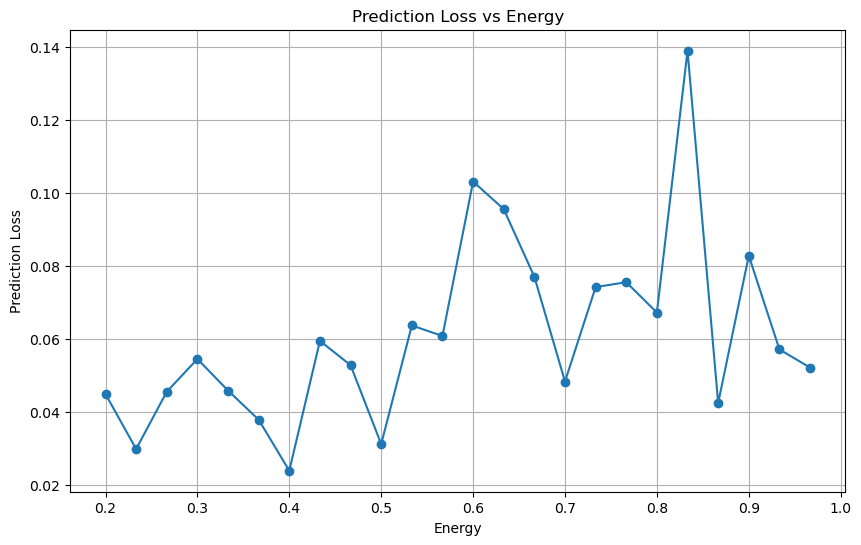

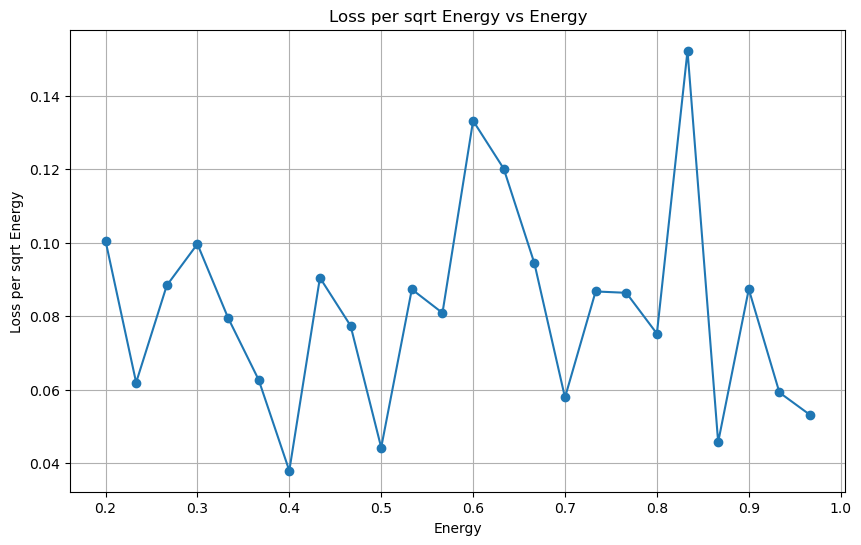

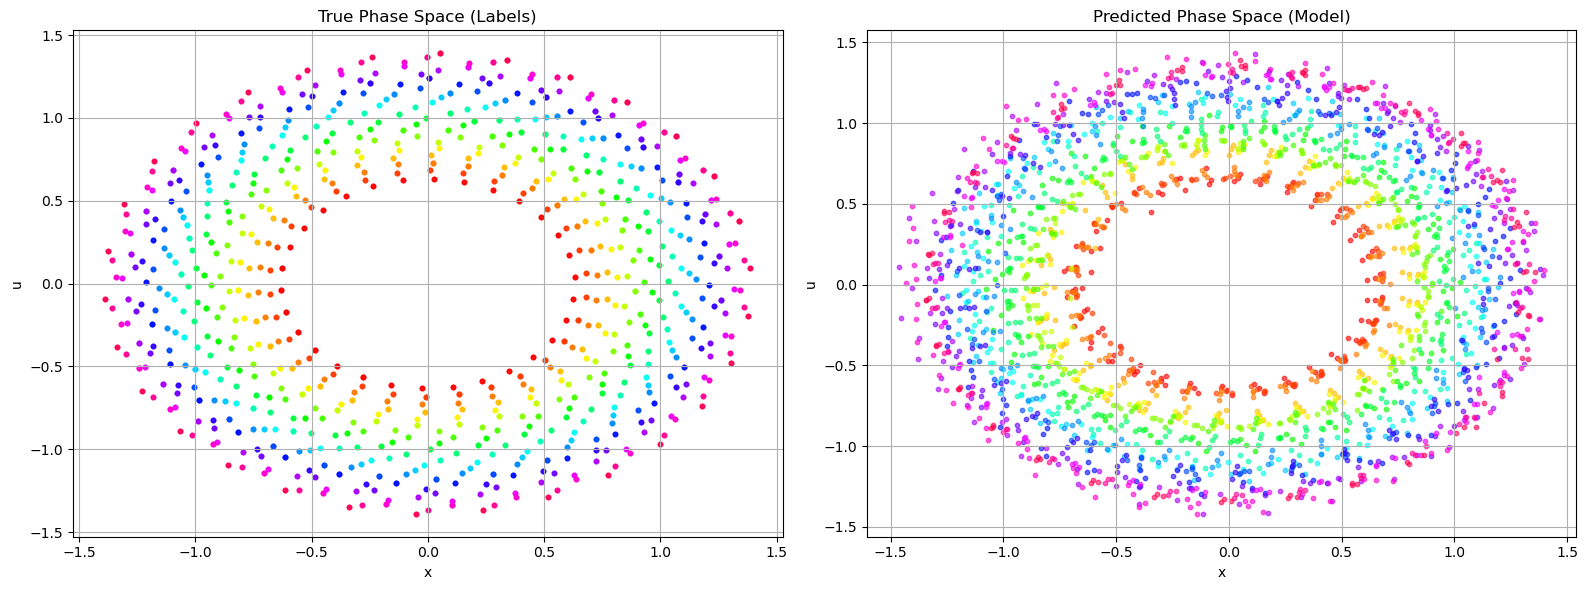

In [12]:
prediction_test_df_multiple_periods, mean_prediction_loss_test_multiple_periods, pred_test_df_multiple_periods = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_low_samples_multiple_periods, 
test_df=test_df_low_samples_multiple_periods, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=True, 
threshold=1.0, 
search_range_lower_pct=0.5, 
search_range_upper_pct=0.6, 
verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  0.200000         0.017228              0.038523
1               1  0.233333         0.010681              0.022112
2               2  0.266667         0.010714              0.020748
3               3  0.300000         0.009384              0.017134
4               4  0.333333         0.020521              0.035543
5               5  0.366667         0.009983              0.016487
6               6  0.400000         0.014811              0.023418
7               7  0.433333         0.015856              0.024087
8               8  0.466667         0.017110              0.025046
9               9  0.500000         0.015873              0.022448
10             10  0.533333         0.020613              0.028226
11             11  0.566667         0.029603              0.039325
12             12  0.600000         0.021050              0.027175
13             13  0.633333         0.029659              0.03

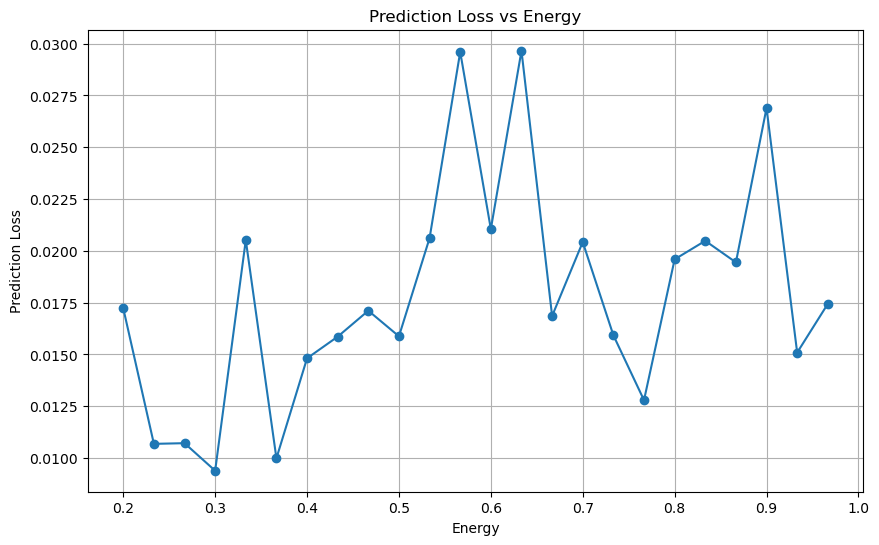

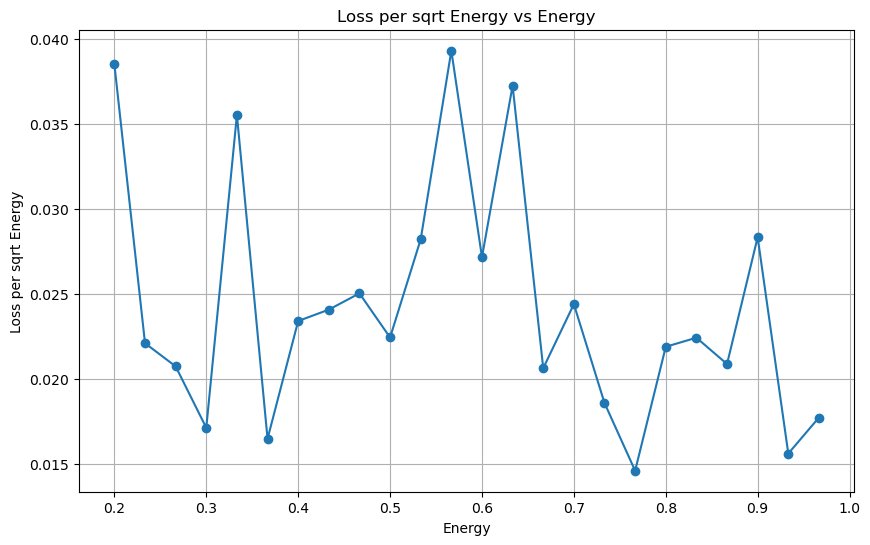

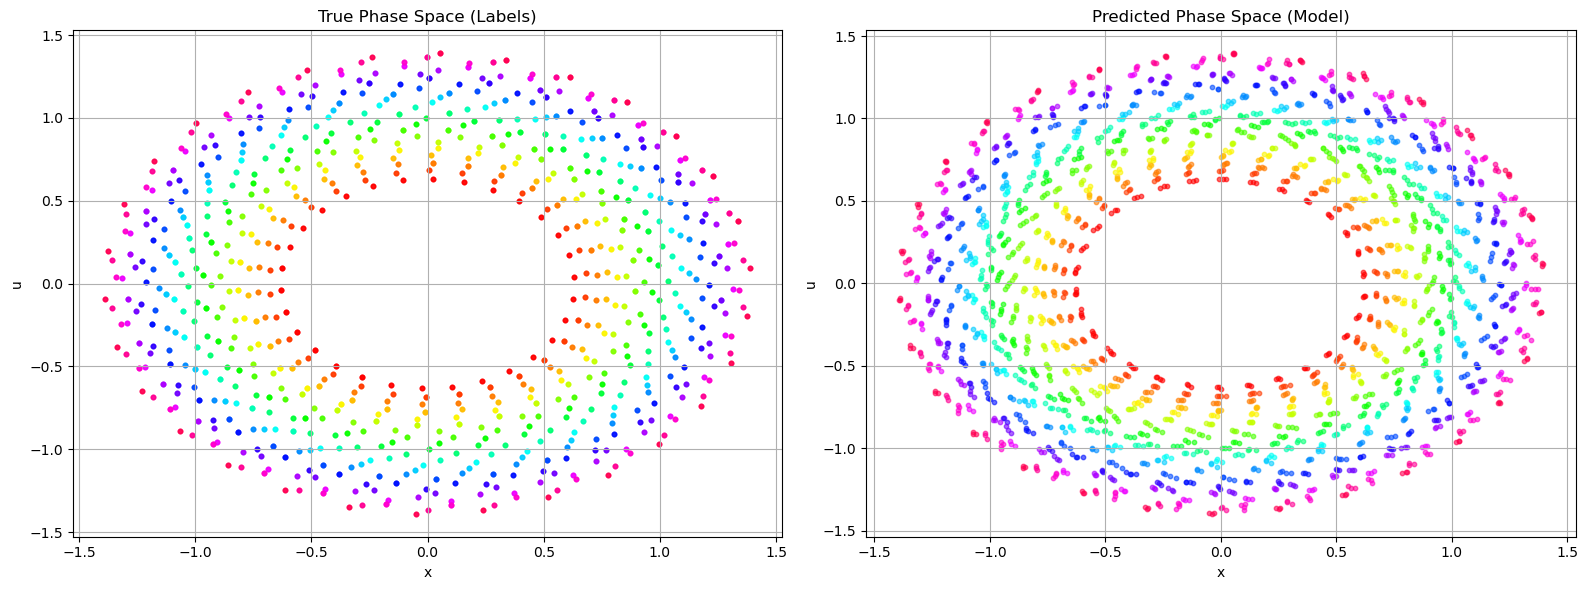

In [13]:
prediction_test_ensemble_df_multiple_periods, mean_prediction_loss_test_ensemble_multiple_periods, pred_test_ensemble_df_multiple_periods = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id,
prediction_loss_function=prediction_loss_euclidean,
test_id_df=test_id_df_low_samples_multiple_periods,
test_df=test_df_low_samples_multiple_periods,
mapping_net=mapping_net,
inverse_net=inverse_net,
device=device, 
point_indexes_observed=point_indexes_observed, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True)

In [19]:
trajectory_id_test_multiple_periods = 6
trajectory_id_test_multiple_periods_ensemble = 6

/tmp/ipykernel_6575/3514698353.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10' if n_trajectories <= 10 else 'tab20' if n_trajectories <= 20 else 'hsv')(np.linspace(0, 1, n_trajectories))
/tmp/ipykernel_6575/3514698353.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


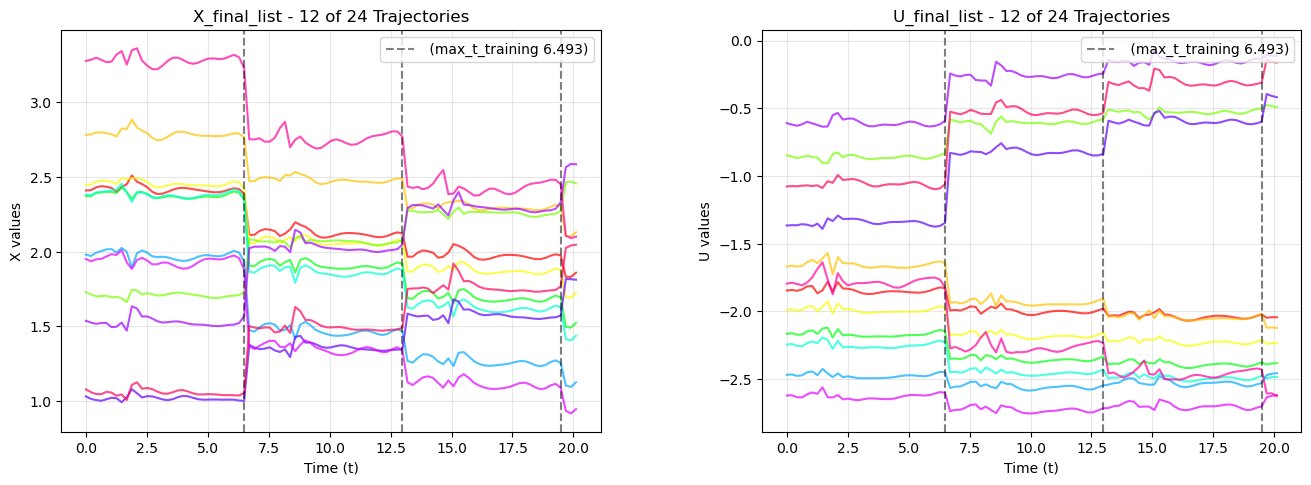

In [80]:
plot_all_transformed_trajectories_multiple_periods(
    test_id_df_low_samples_multiple_periods, 
    test_df_low_samples_multiple_periods, 
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    only_plot_percentage=0.5
)


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8
Observed time points: [0.]


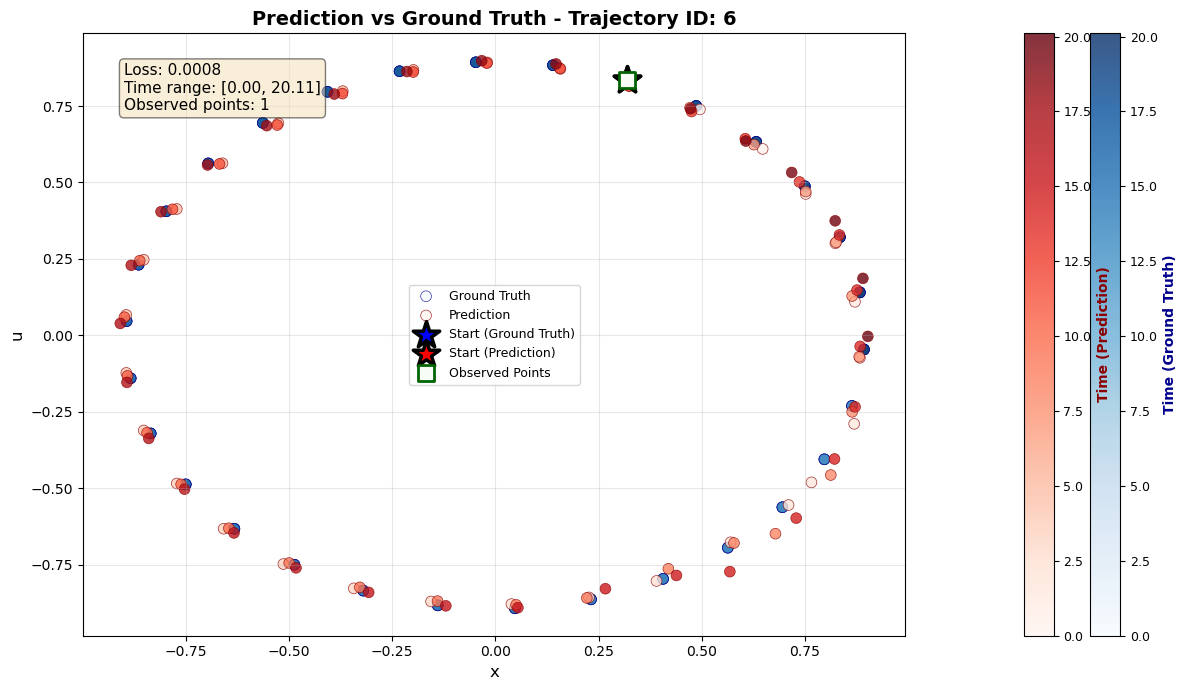

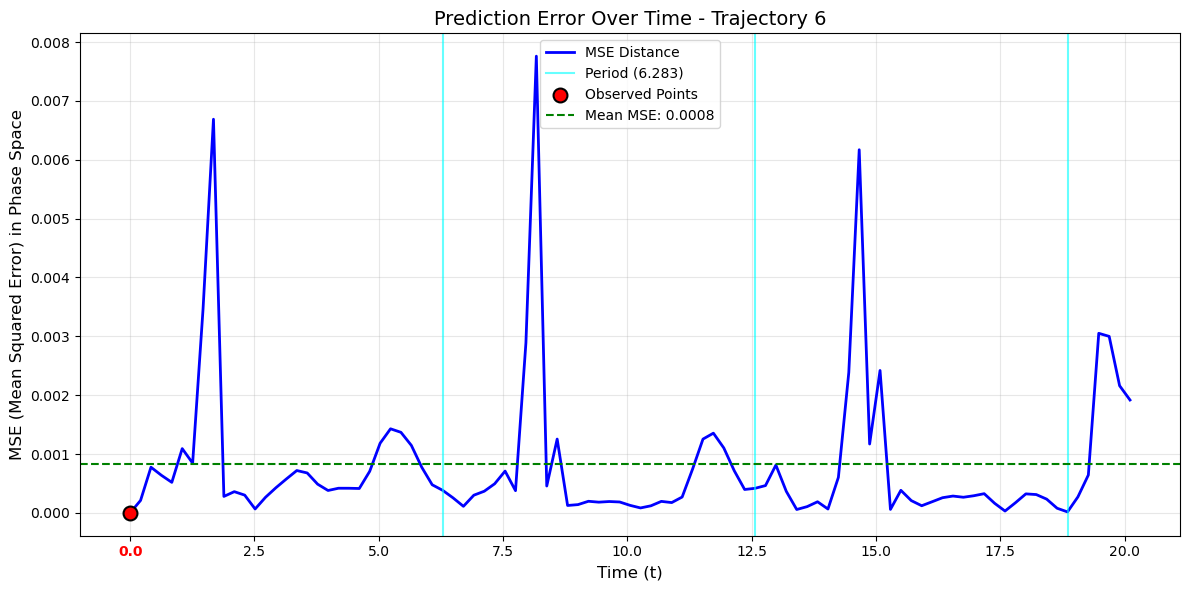

In [25]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_multiple_periods, test_df=test_df_low_samples_multiple_periods, trajectory_id=trajectory_id_test_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

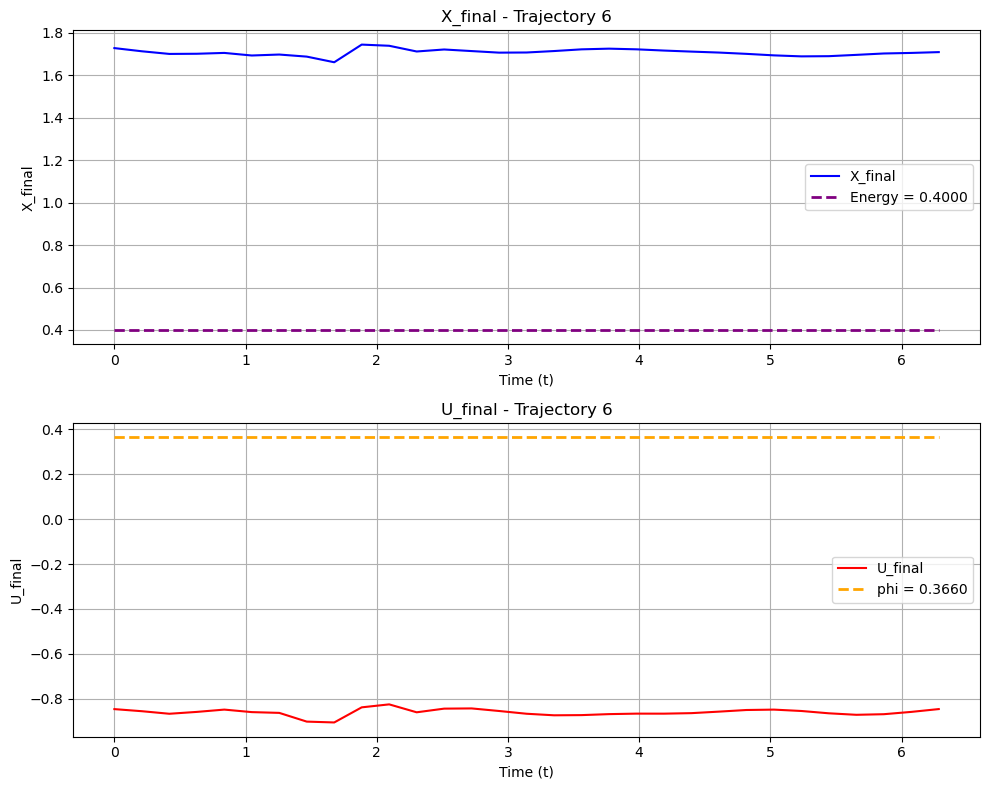

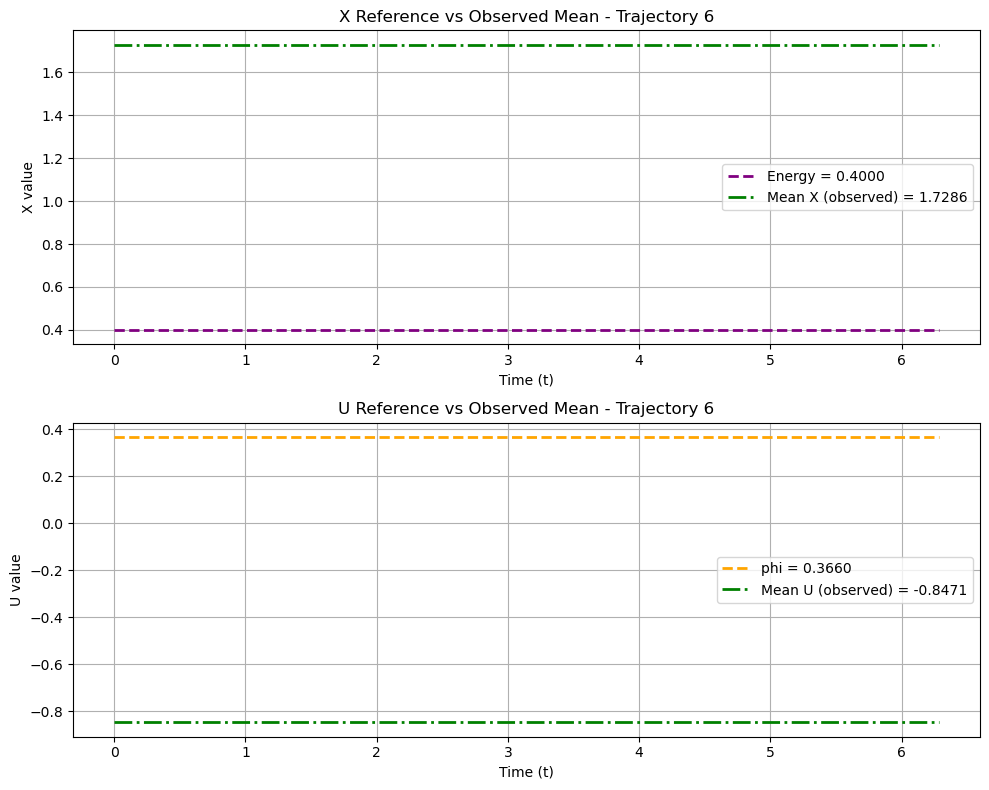

In [26]:

plot_transformed_trajectory(
    test_id_df_low_samples_multiple_periods, 
    test_df_low_samples_multiple_periods, 
    trajectory_id=trajectory_id_test_multiple_periods,  
    get_data_from_trajectory_id_function=get_data_from_trajectory_id, mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=False,
    point_indexes_observed=point_indexes_observed)




=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8


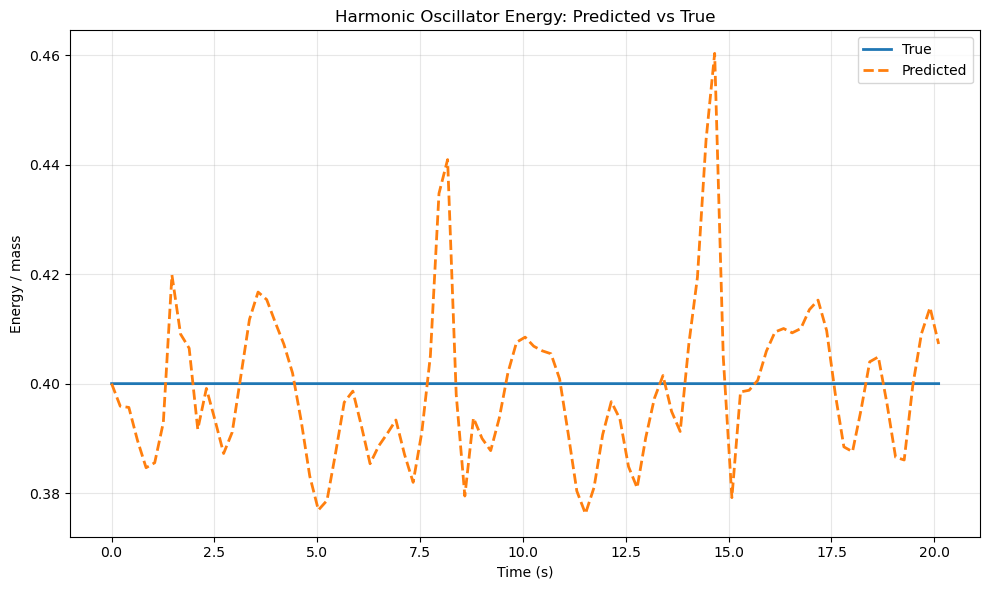

In [27]:
test_model_energy_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_low_samples_multiple_periods, test_df=test_df_low_samples_multiple_periods, trajectory_id=trajectory_id_test_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6,length=1.0, k=1, mass=1, g=3.0, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 14
inverse_net calls: 780
Total forward passes: 794
Coverage: 100.0%
Observed time points: [0.]


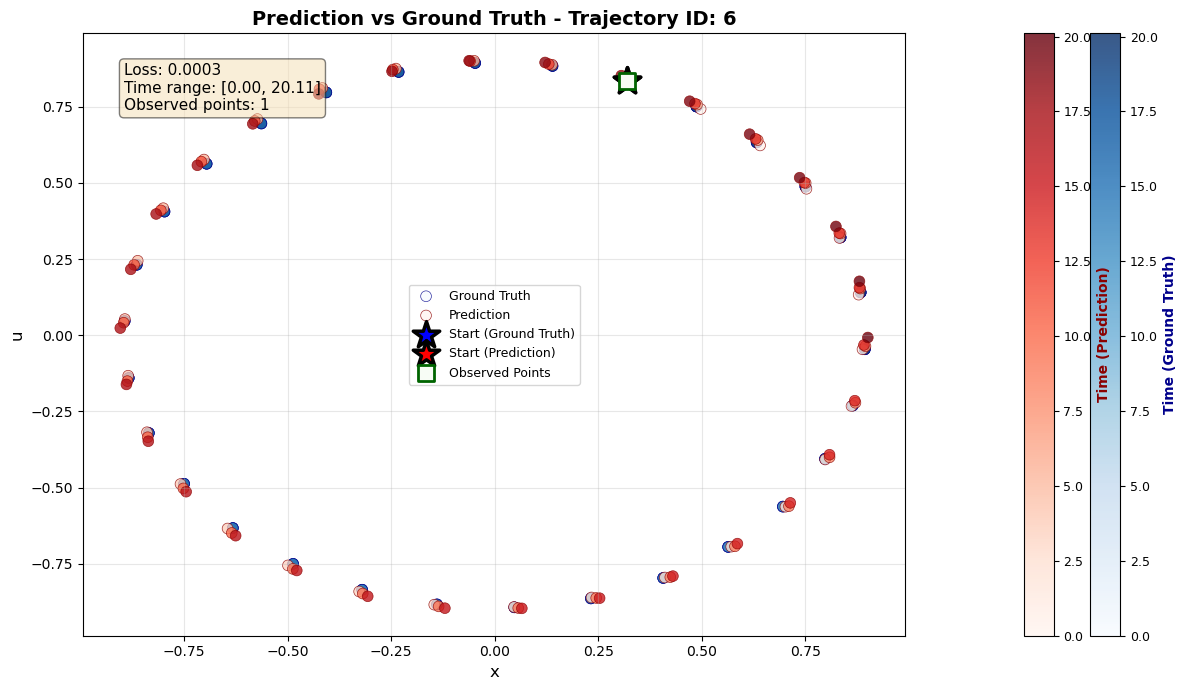

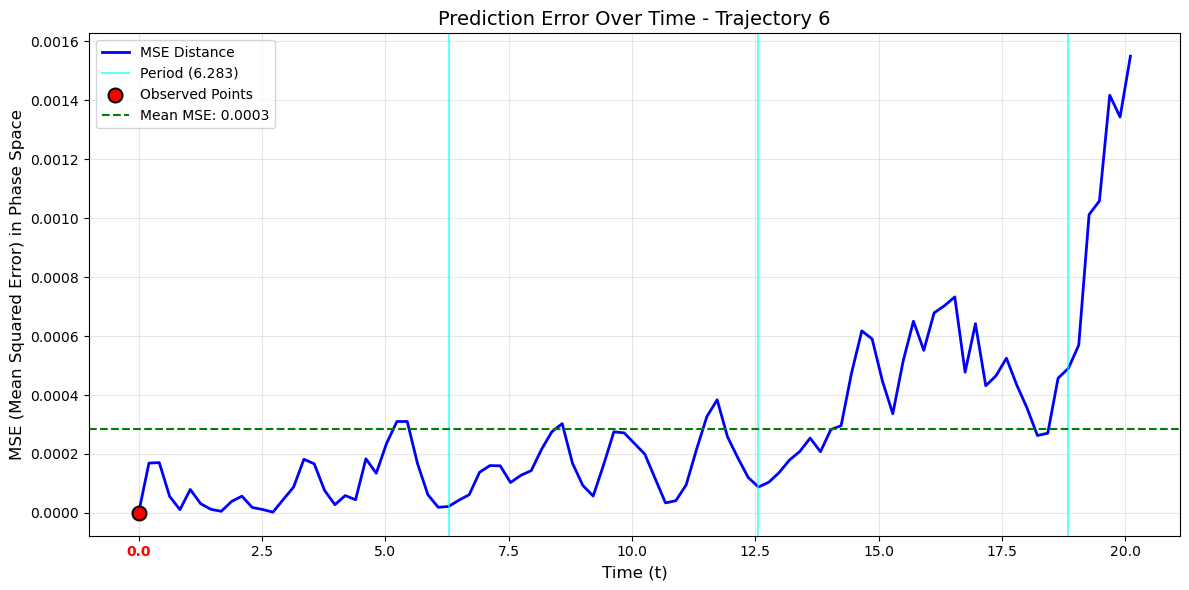

In [20]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_low_samples_multiple_periods, 
test_df=test_df_low_samples_multiple_periods, 
trajectory_id=trajectory_id_test_multiple_periods_ensemble, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=None, 
show_zeroings=None, 
show_period=True, 
period=period, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 14
inverse_net calls: 780
Total forward passes: 794
Coverage: 100.0%


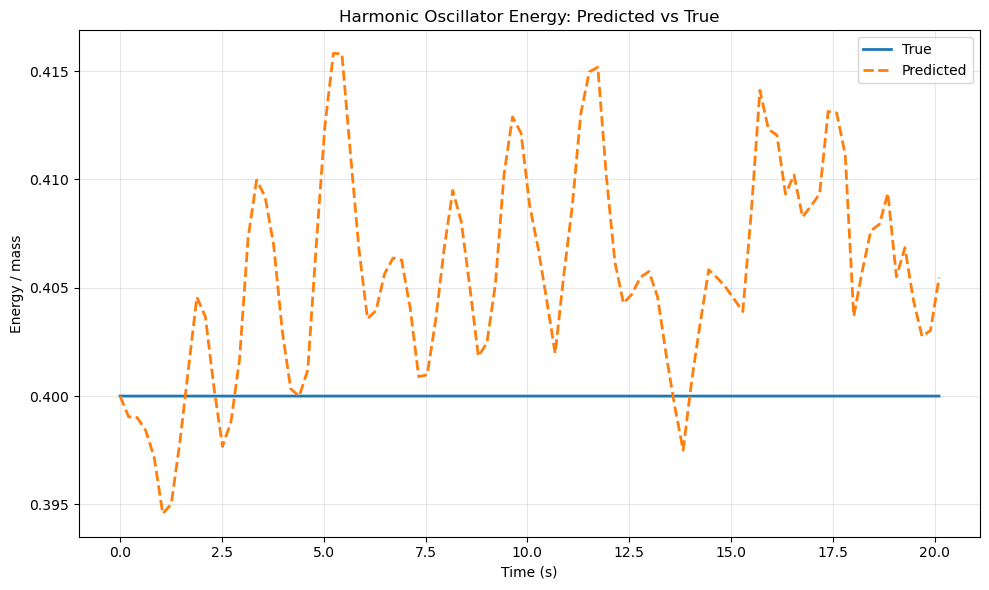

In [21]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
test_id_df=test_id_df_low_samples_multiple_periods, 
test_df=test_df_low_samples_multiple_periods, 
trajectory_id=trajectory_id_test_multiple_periods, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
length=1.0, k=1, mass=1, g=3.0, 
verbose=True)

In [28]:
print(f"The max energy of a trajectory in the training set is: {train_id_df_low_samples['energy'].max():.3f}\nThe high energy testing set has energies in the range: {test_id_df_high_energy_low_samples['energy'].min():.3f}-{test_id_df_high_energy_low_samples['energy'].max():.3f}")

The max energy of a trajectory in the training set is: 0.968
The high energy testing set has energies in the range: 1.118-1.942


   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.004499
2                    3       0.005835
3                    4       0.005121
4                    5       0.004821
5                    6       0.006648
6                    7       0.005836
7                    8       0.005834
8                    9       0.010953
9                   10       0.009903


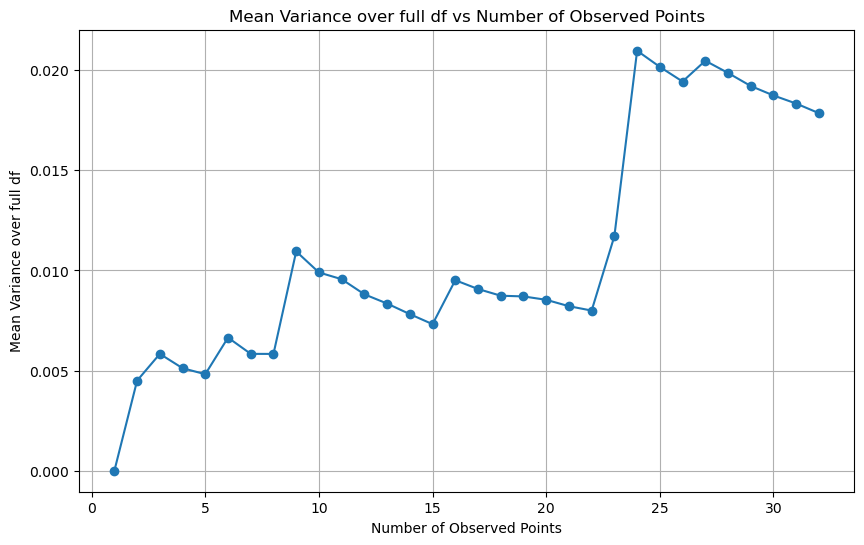

In [18]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id ,test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net ,device=device)

/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:11277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


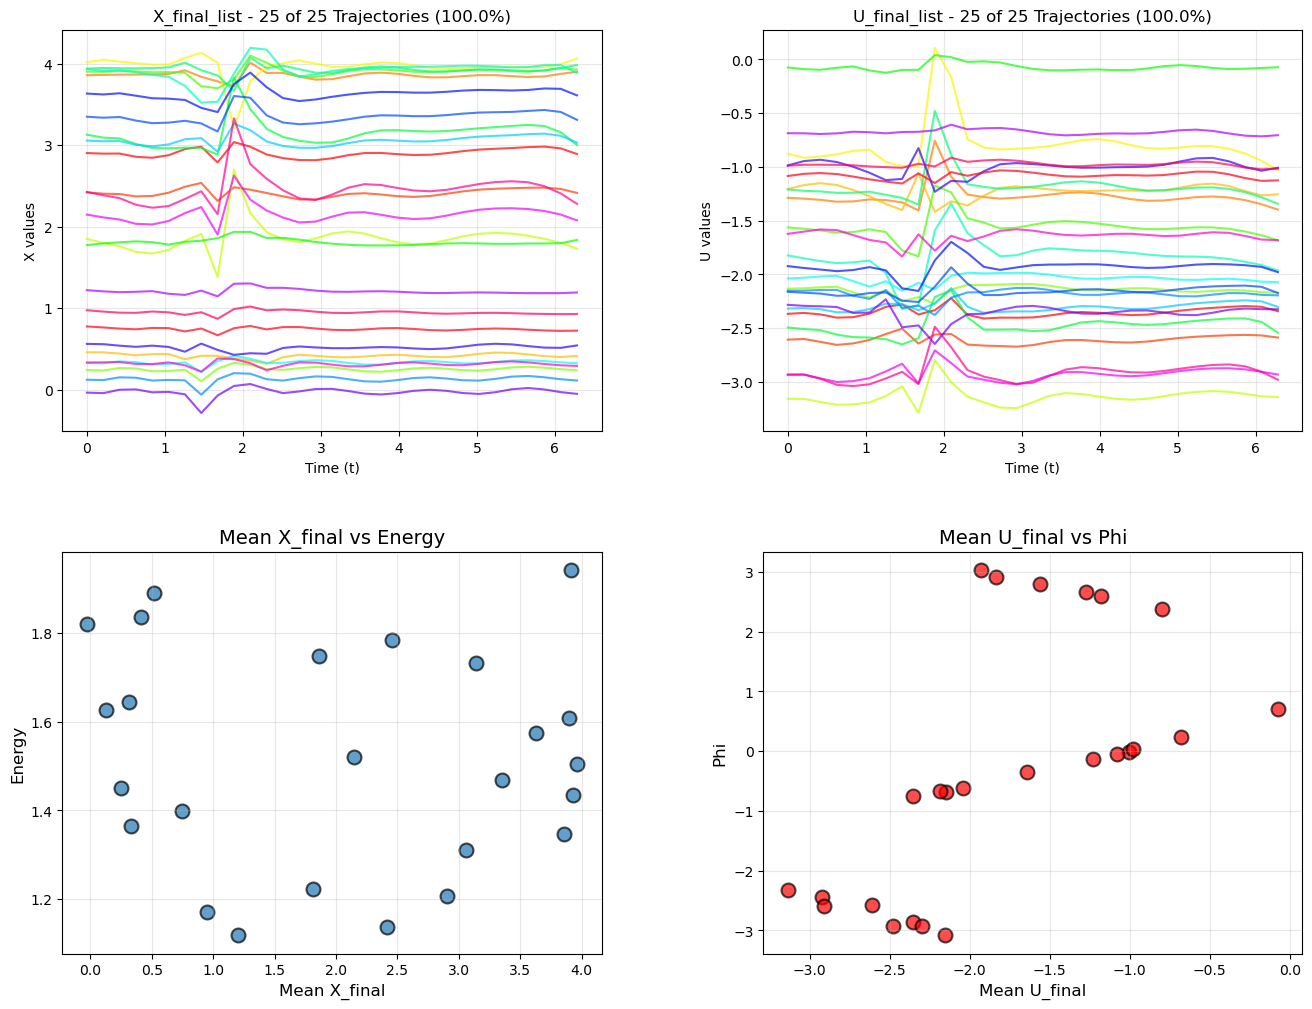

In [22]:
plot_all_transformed_trajectories(
    test_id_df_high_energy_low_samples_added, 
    test_df_high_energy_low_samples, 
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=False,
    only_plot_percentage=1.0
)

In [22]:
point_indexes_observed_high_energy = [0]

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  1.117551         0.036112              0.034160
2               2  1.135102         0.044589              0.041851
4               4  1.170204         0.042138              0.038953
6               6  1.205306         0.052363              0.047695
7               7  1.222857         0.052289              0.047285
12             12  1.310612         0.058587              0.051176
14             14  1.345714         0.058791              0.050680
15             15  1.363265         0.042077              0.036037
17             17  1.398367         0.046933              0.039689
19             19  1.433469         0.076103              0.063564
20             20  1.451020         0.046782              0.038836
21             21  1.468571         0.072351              0.059703
23             23  1.503673         0.126601              0.103243
24             24  1.521224         0.076971              0.06

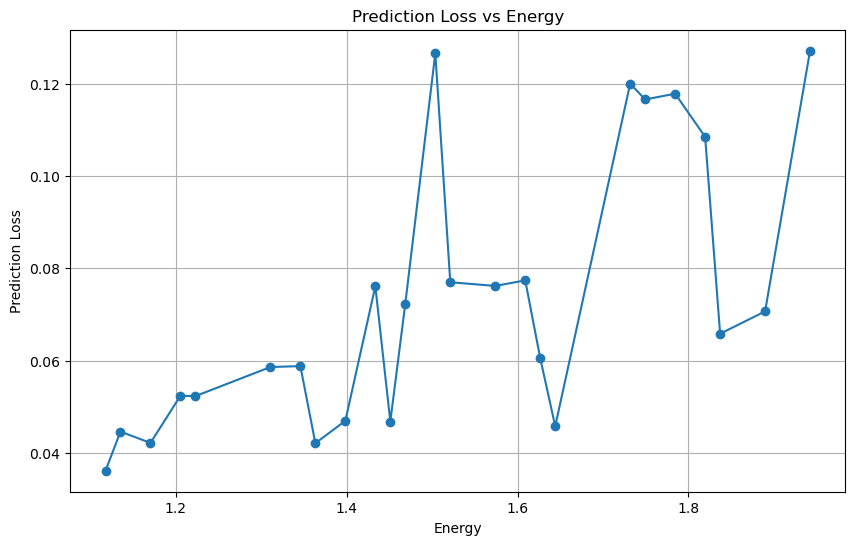

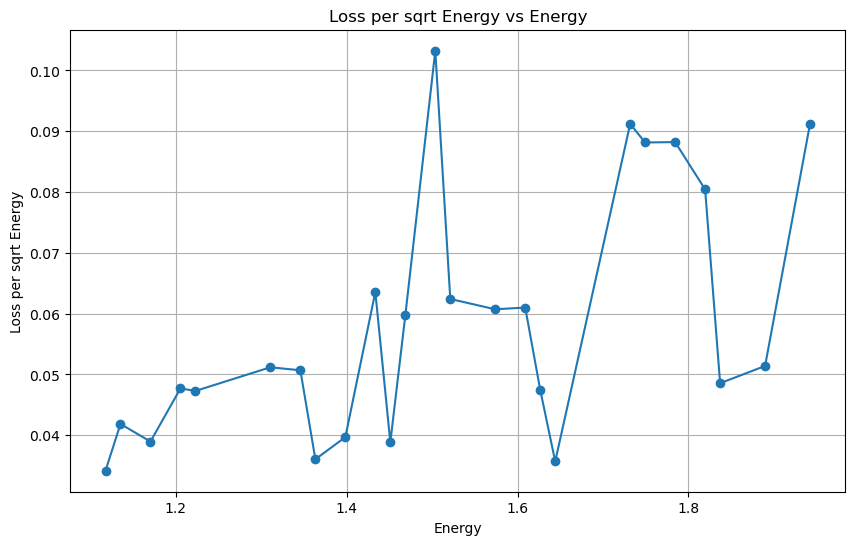

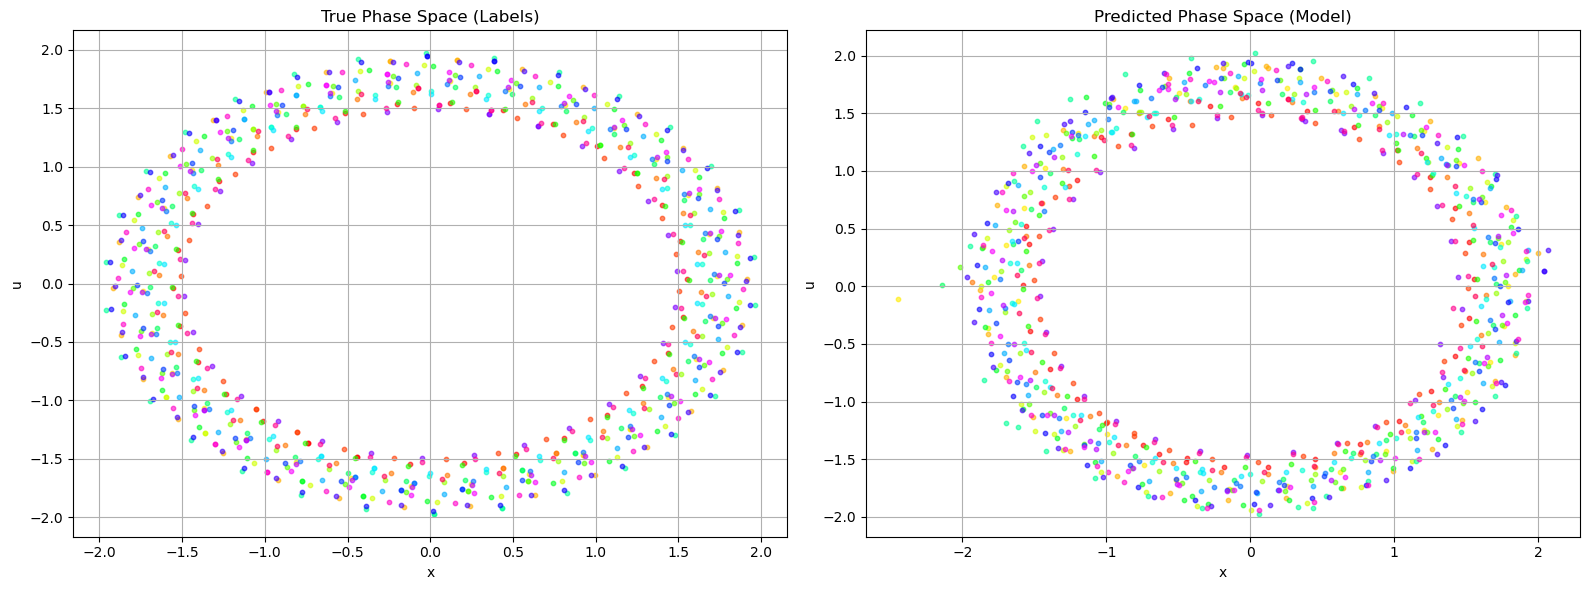

In [31]:
prediction_test_high_energy_df, mean_prediction_loss_test_high_energy, pred_test_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=1.0, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  1.117551         0.016058              0.015190
2               2  1.135102         0.025959              0.024365
4               4  1.170204         0.017232              0.015930
6               6  1.205306         0.032950              0.030013
7               7  1.222857         0.025213              0.022801
12             12  1.310612         0.042740              0.037333
14             14  1.345714         0.022787              0.019643
15             15  1.363265         0.029694              0.025432
17             17  1.398367         0.021089              0.017834
19             19  1.433469         0.027122              0.022653
20             20  1.451020         0.032135              0.026677
21             21  1.468571         0.019057              0.015725
23             23  1.503673         0.041684              0.033993
24             24  1.521224         0.034851              0.02

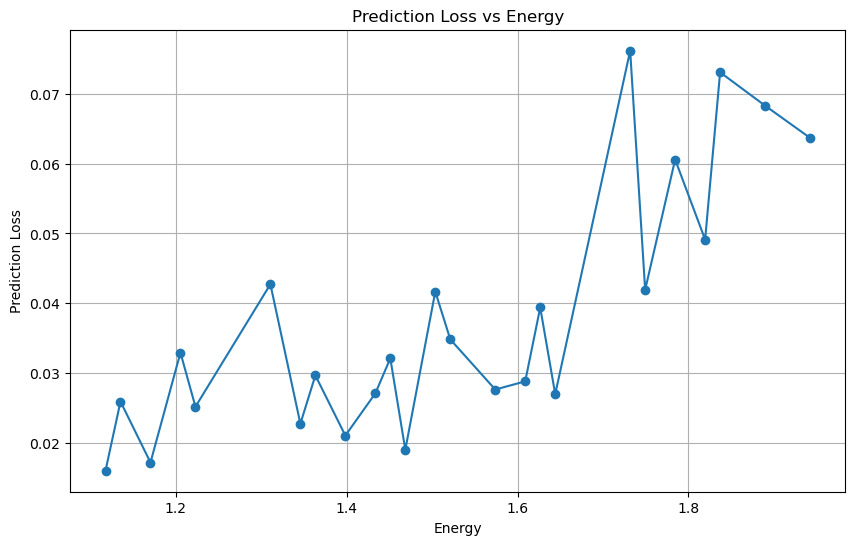

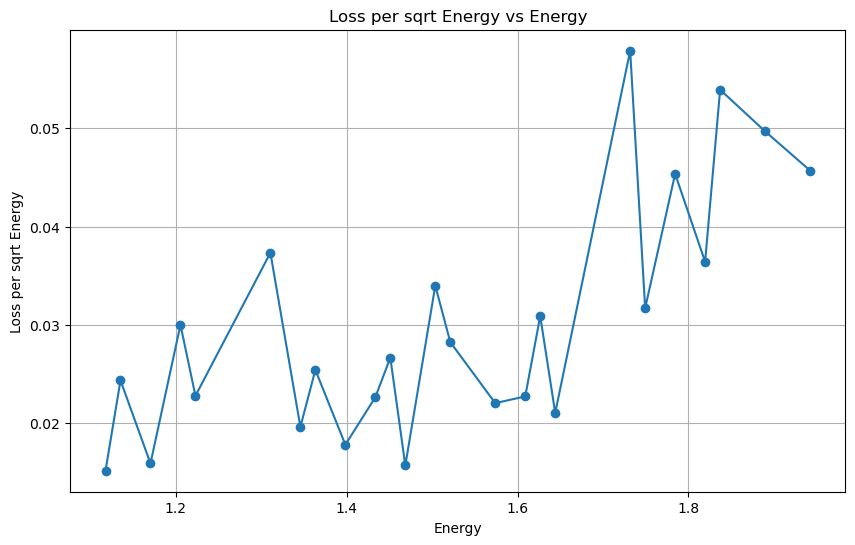

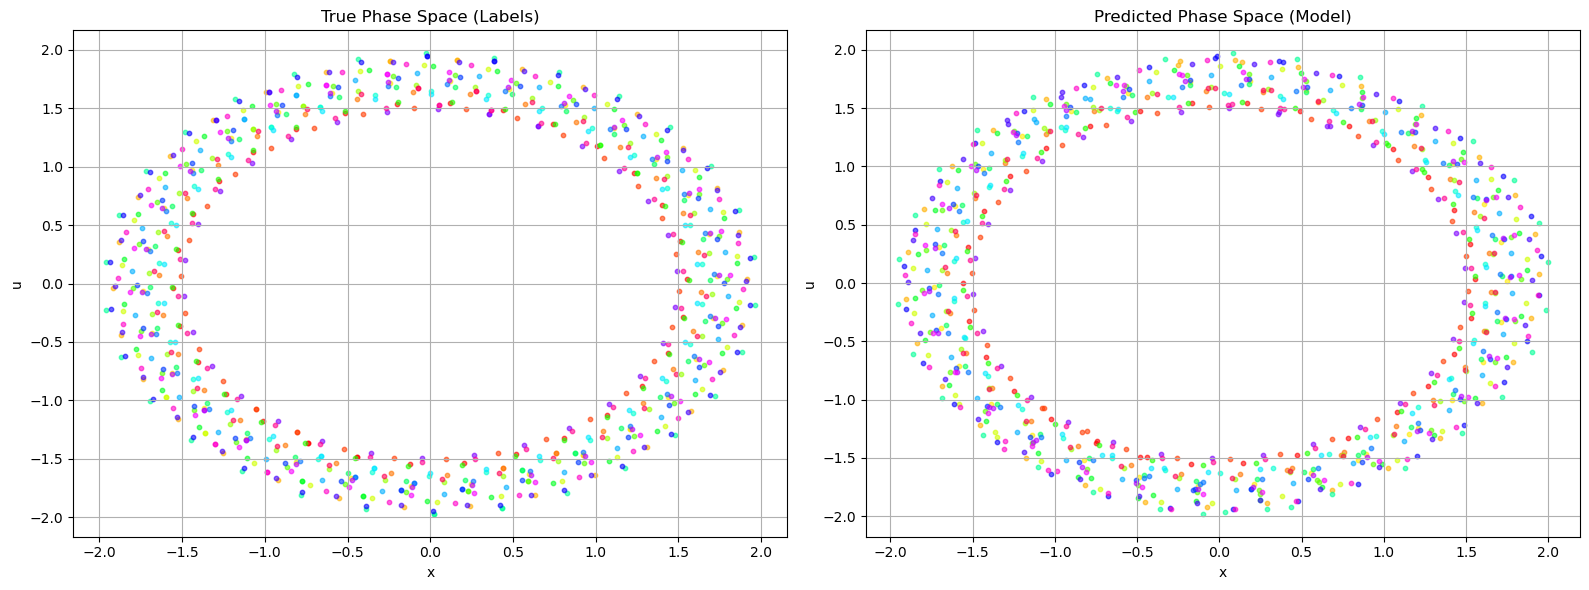

In [23]:
prediction_test_ensemble_high_energy_df, mean_prediction_loss_test_ensemble_high_energy, pred_test_ensemble_high_energy_df = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_high_energy_low_samples, 
test_df=test_df_high_energy_low_samples, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed_high_energy, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True)

In [15]:
trajectory_id_high_energy = 48
trajectory_id_high_energy_ensemble = 48


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


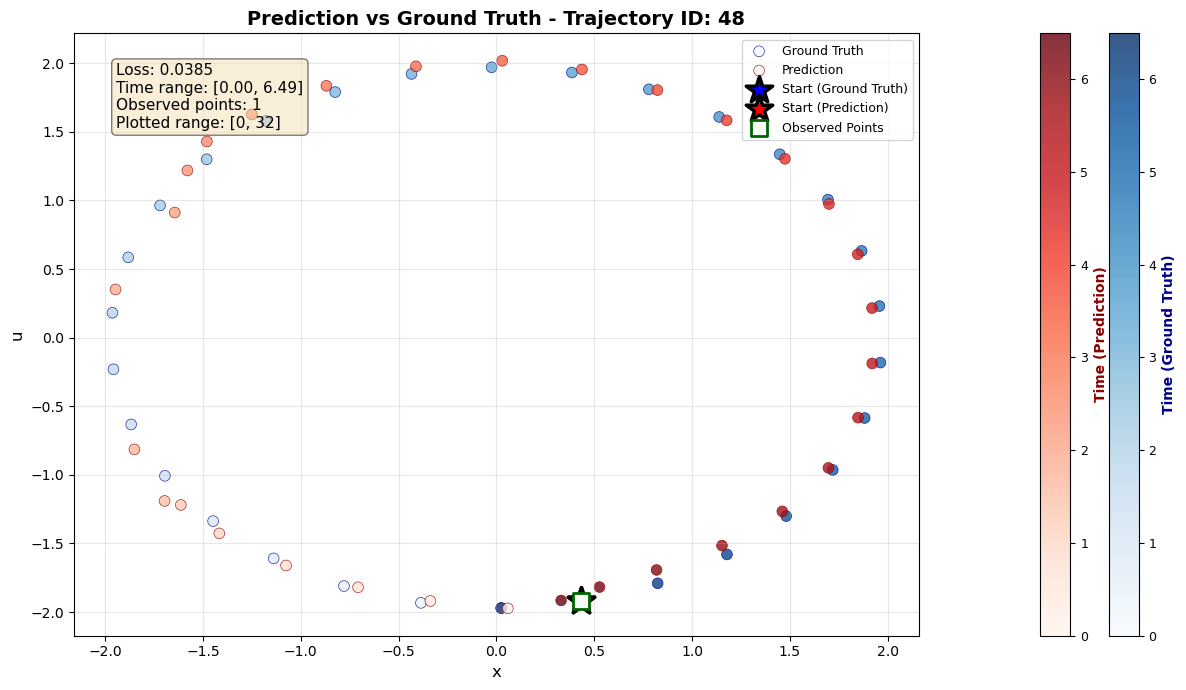

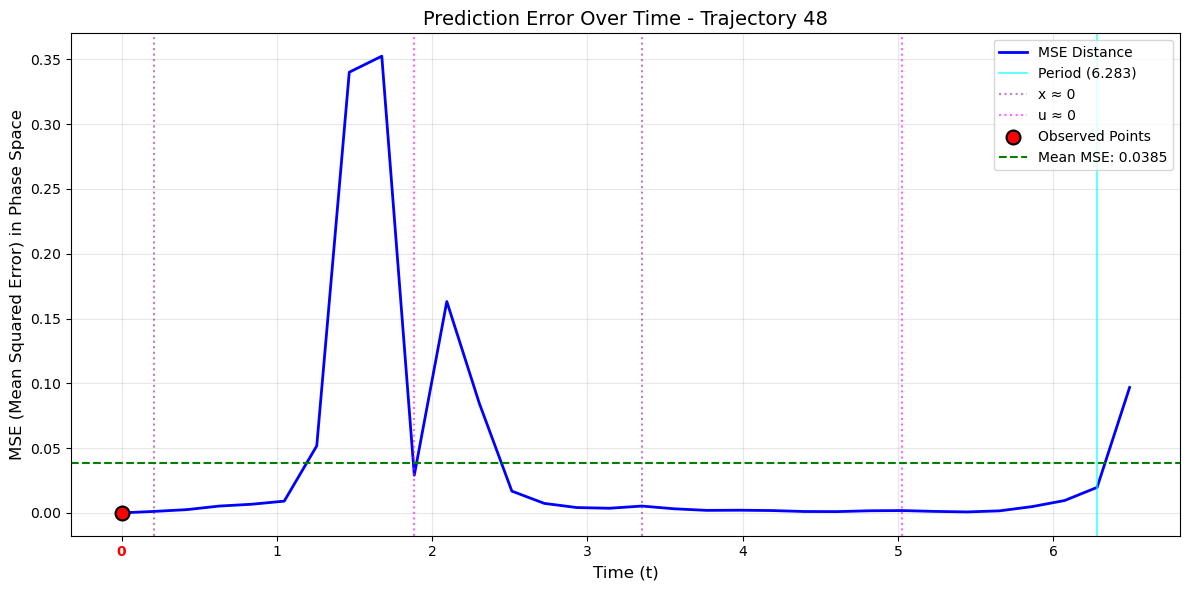

In [33]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, trajectory_id=trajectory_id_high_energy, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2


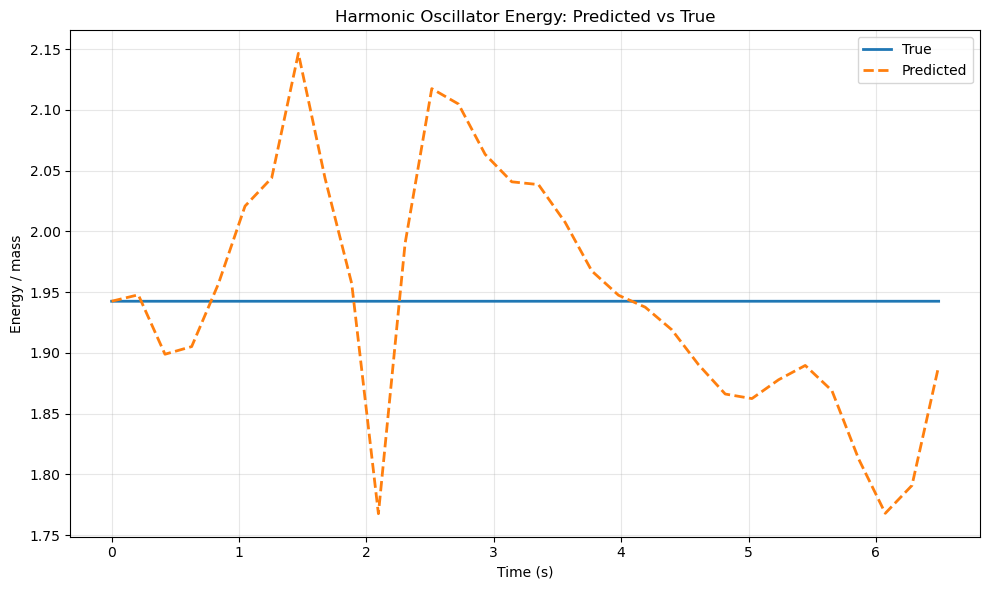

In [16]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
test_id_df=test_id_df_high_energy_low_samples, 
test_df=test_df_high_energy_low_samples, 
trajectory_id=trajectory_id_high_energy, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
max_t_training=max_t_training, 
efficiently=True, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
length=1.0, k=1, mass=1, g=3.0, 
verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 126
Total forward passes: 130
Coverage: 100.0%
Observed time points: [0.]


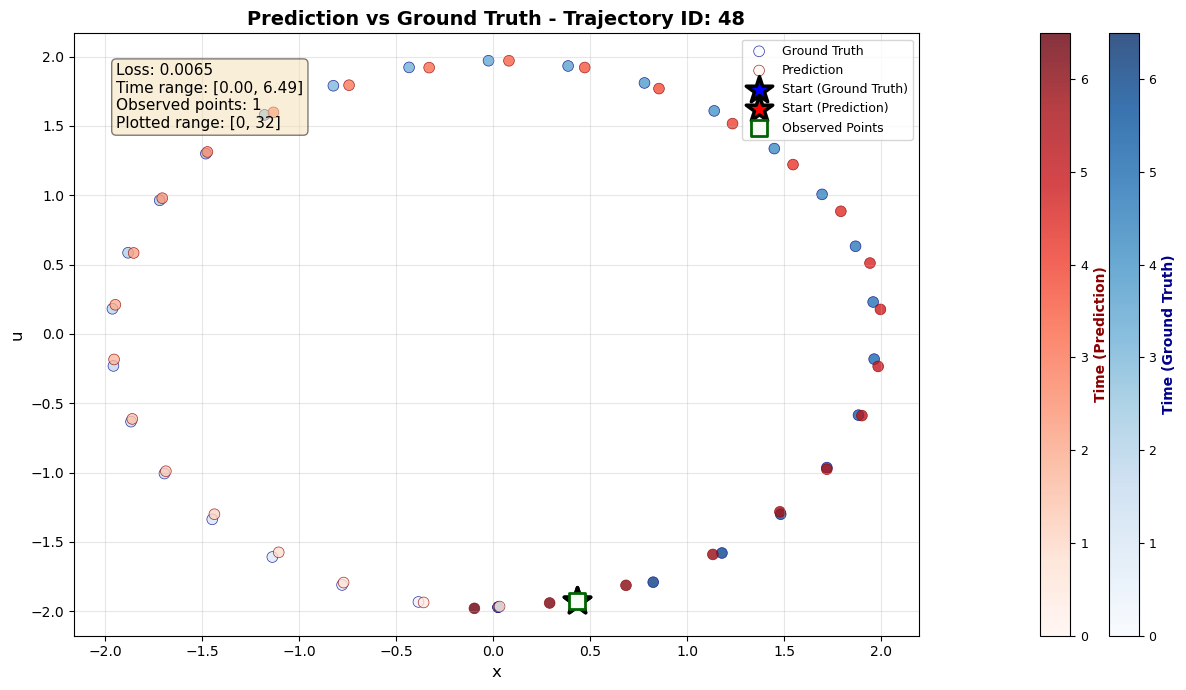

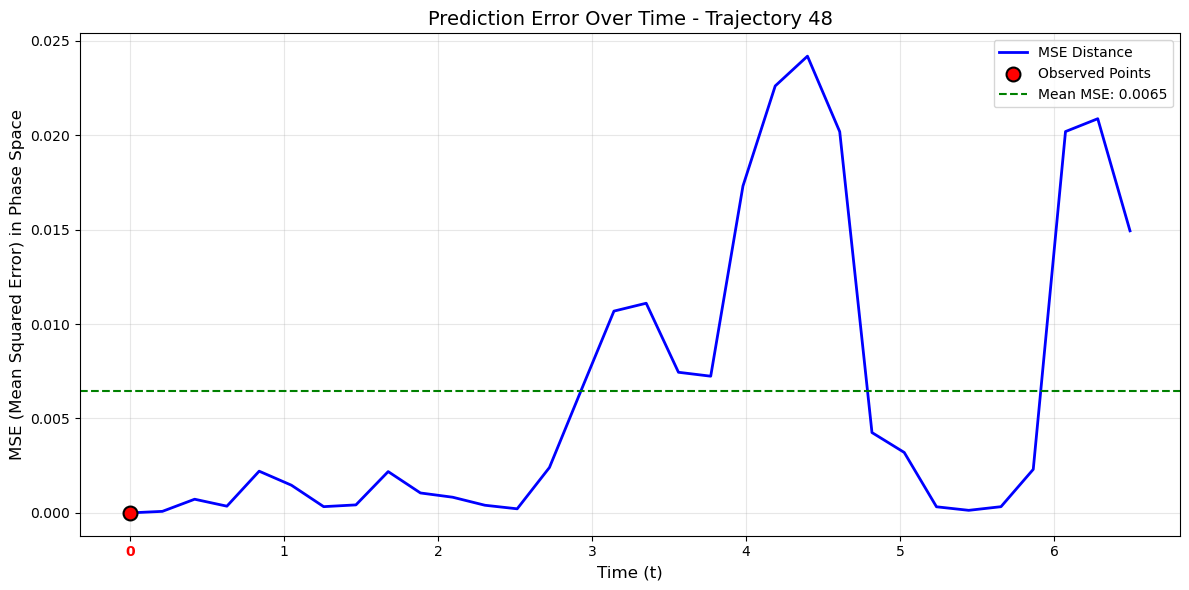

In [25]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_high_energy_low_samples, 
test_df=test_df_high_energy_low_samples, 
trajectory_id=trajectory_id_high_energy_ensemble, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed_high_energy, 
connect_points=False, 
portion_to_visualize=[0,32], 
show_zeroings=False, 
show_period=False, 
period=period, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True,
plot=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 126
Total forward passes: 130
Coverage: 100.0%


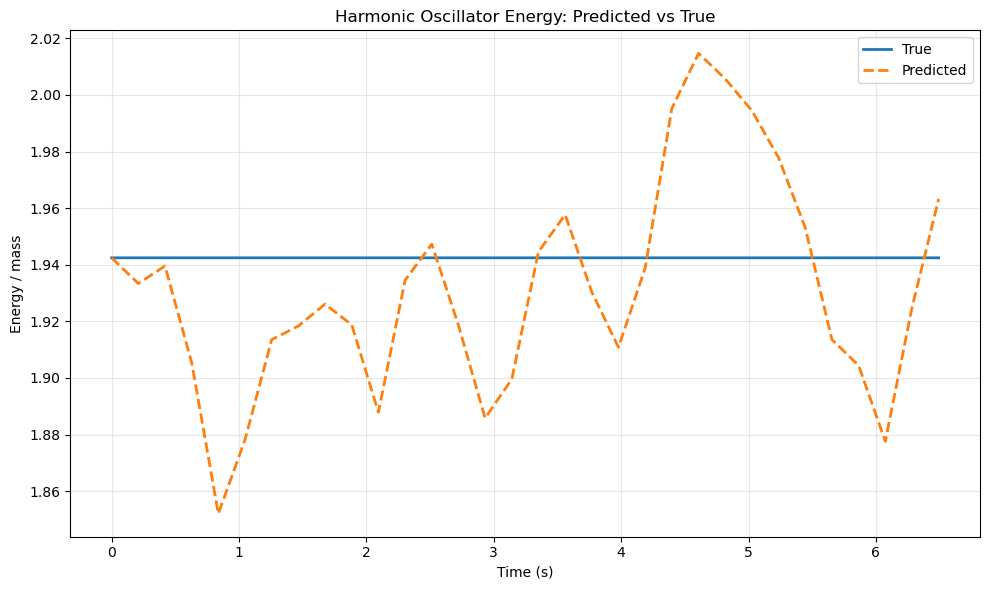

In [17]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
test_id_df=test_id_df_high_energy_low_samples, 
test_df=test_df_high_energy_low_samples, 
trajectory_id=trajectory_id_high_energy, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
length=1.0, k=1, mass=1, g=3.0, 
verbose=True)

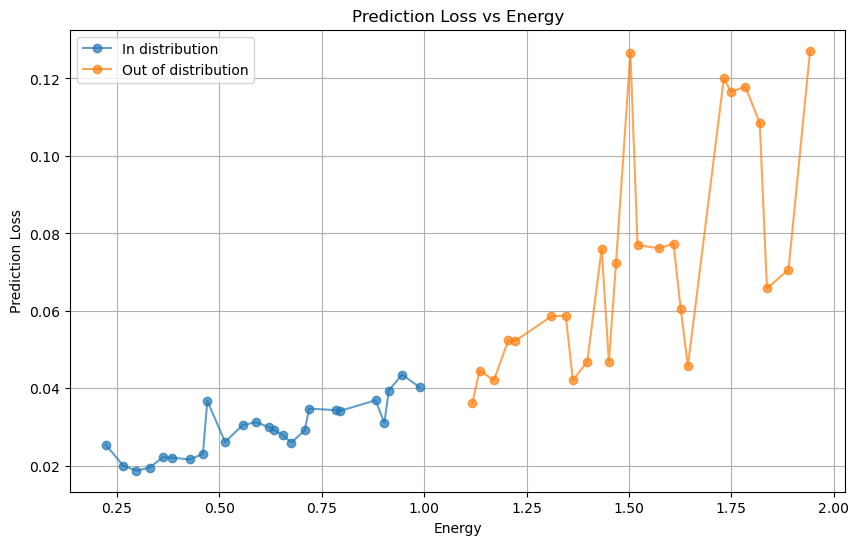

In [34]:
plot_prediction_losses([prediction_test_df, prediction_test_high_energy_df])

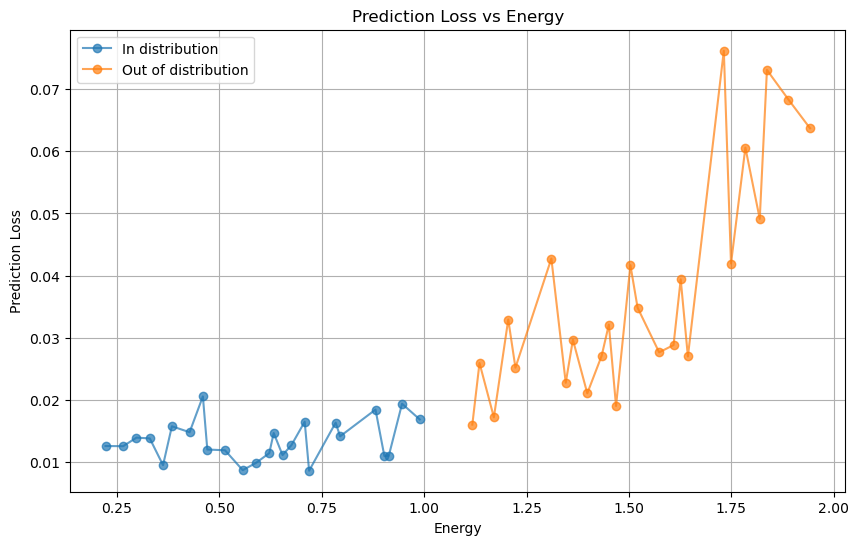

In [26]:
plot_prediction_losses([prediction_test_ensemble_df, prediction_test_ensemble_high_energy_df])

Step 1 gamma values mean: 1.892±0.276

Step 2 gamma values mean: 2.002±0.126



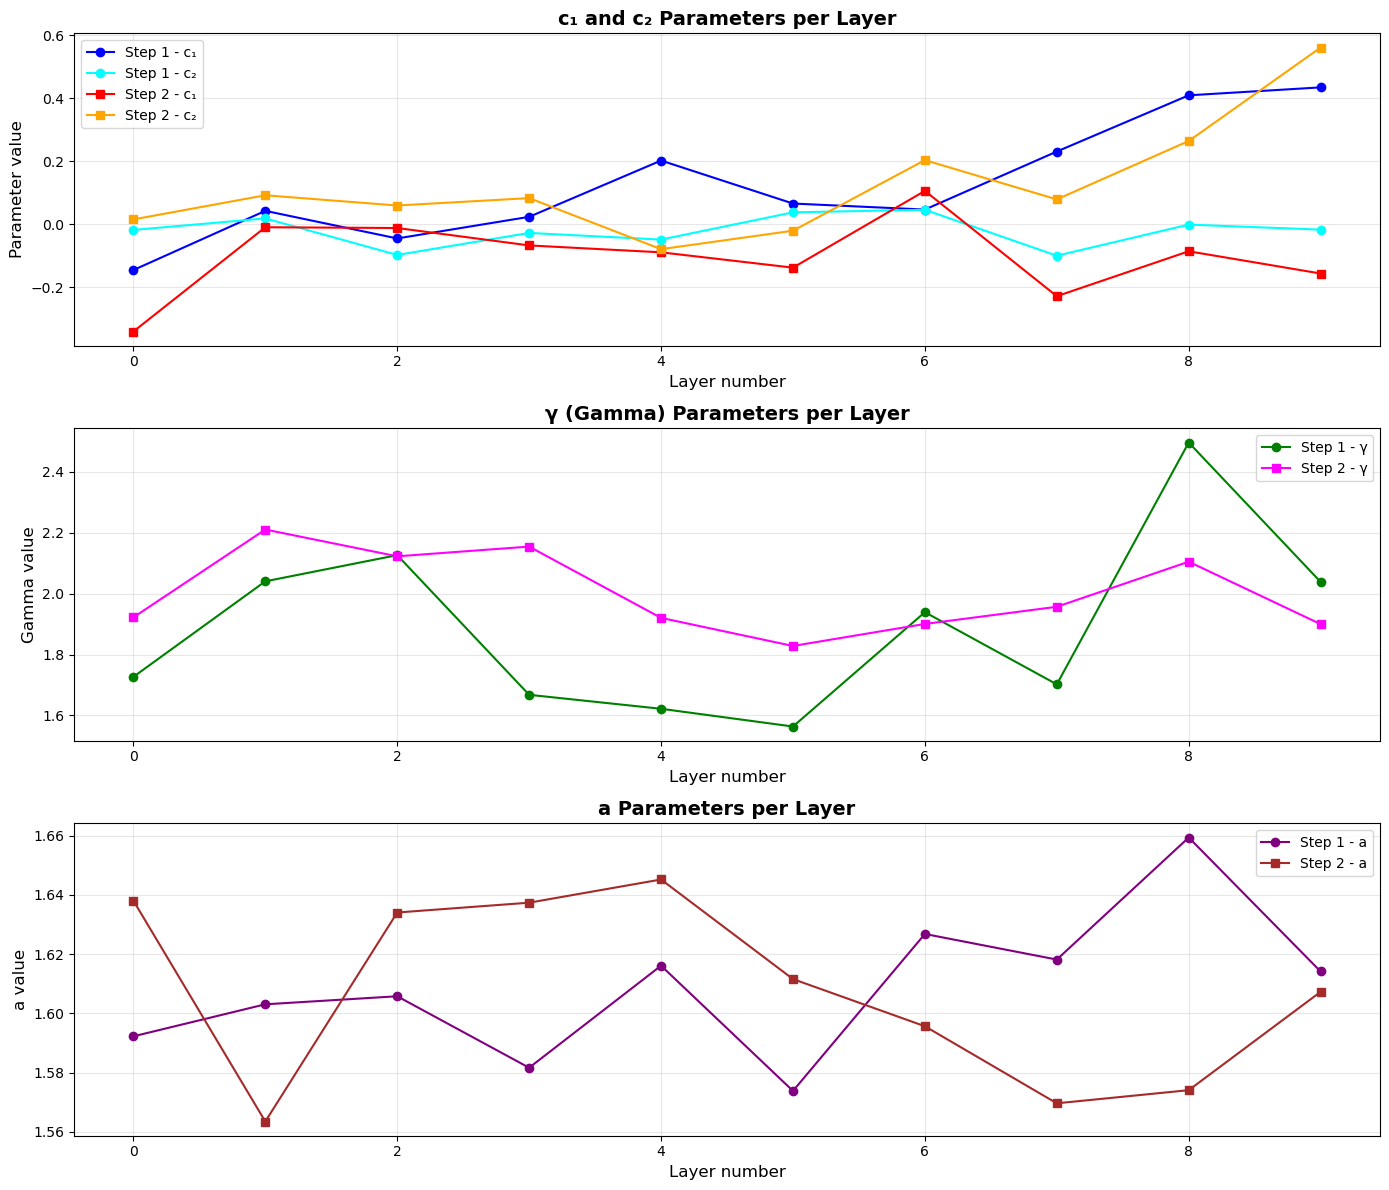

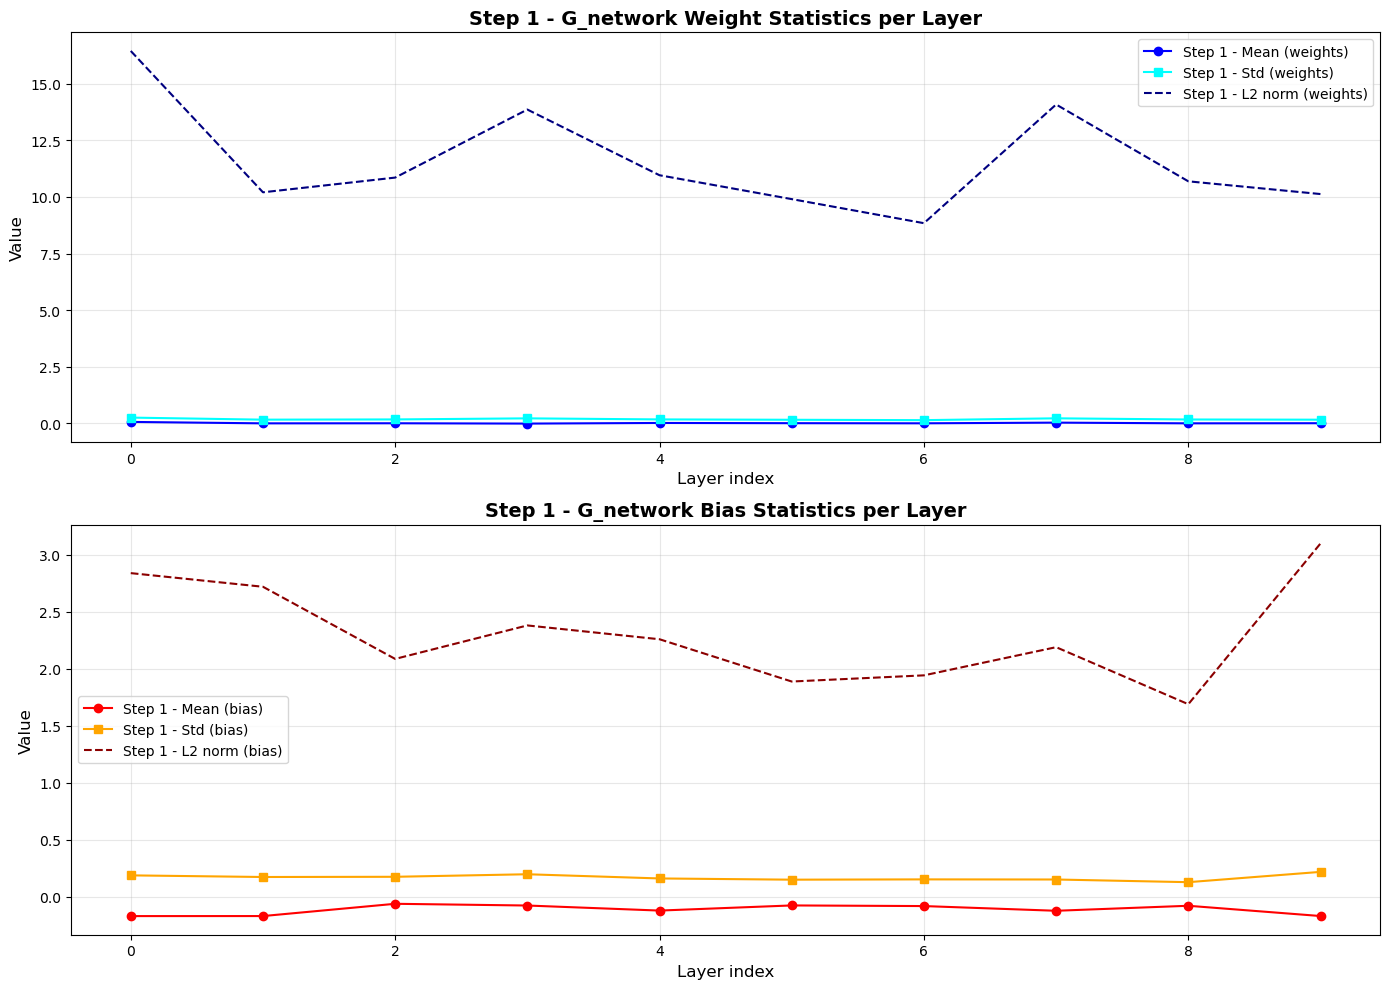

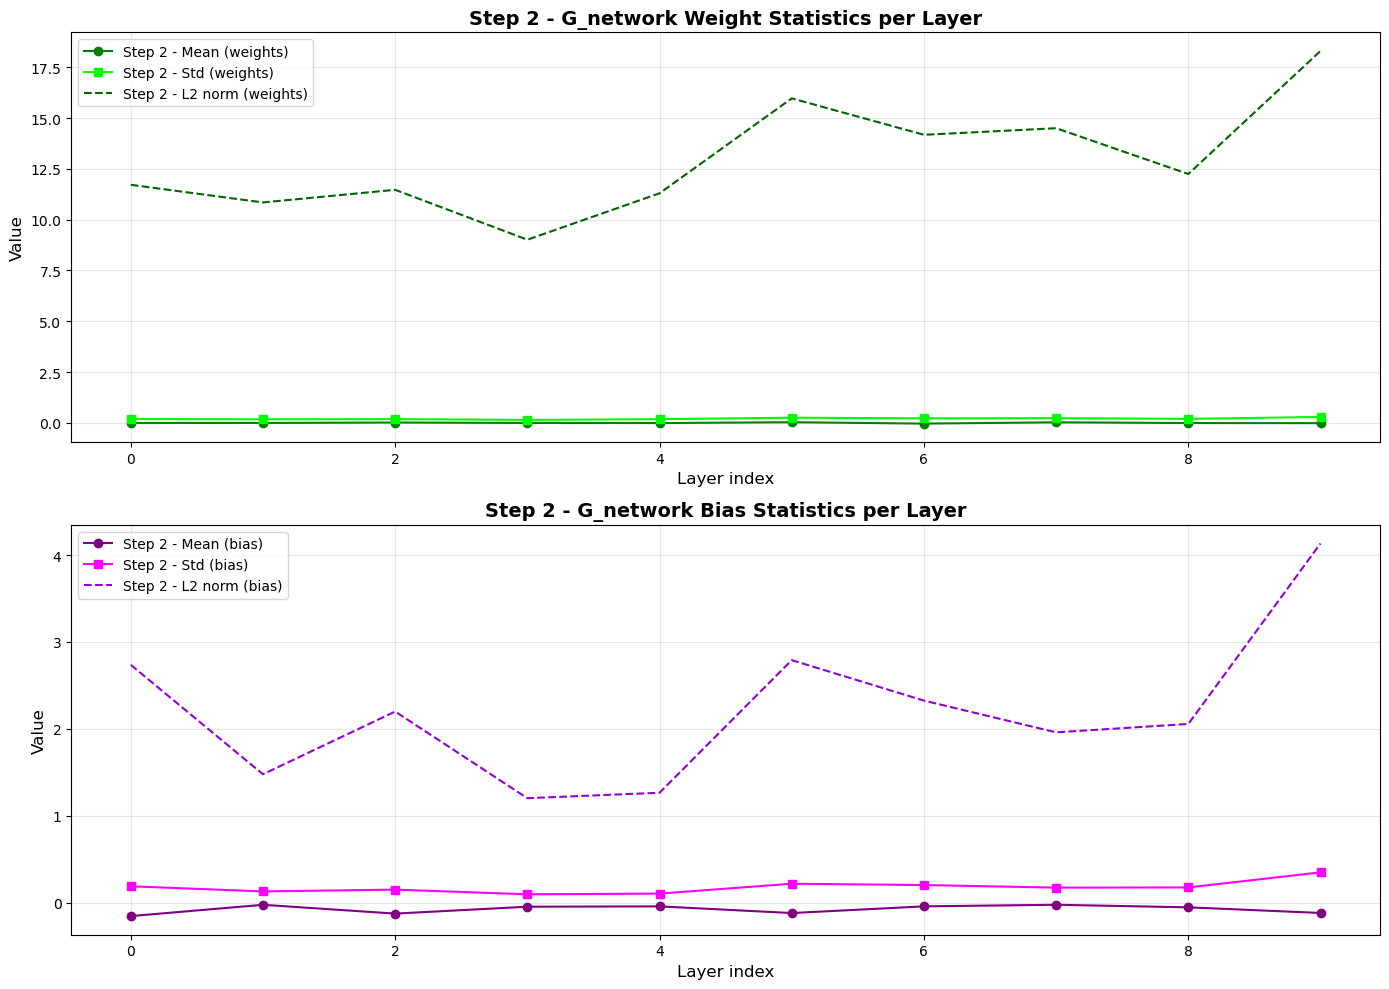

In [35]:
param_data = analyze_mapping_net(mapping_net, return_lists=True)



=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8
Observed time points: [0.]


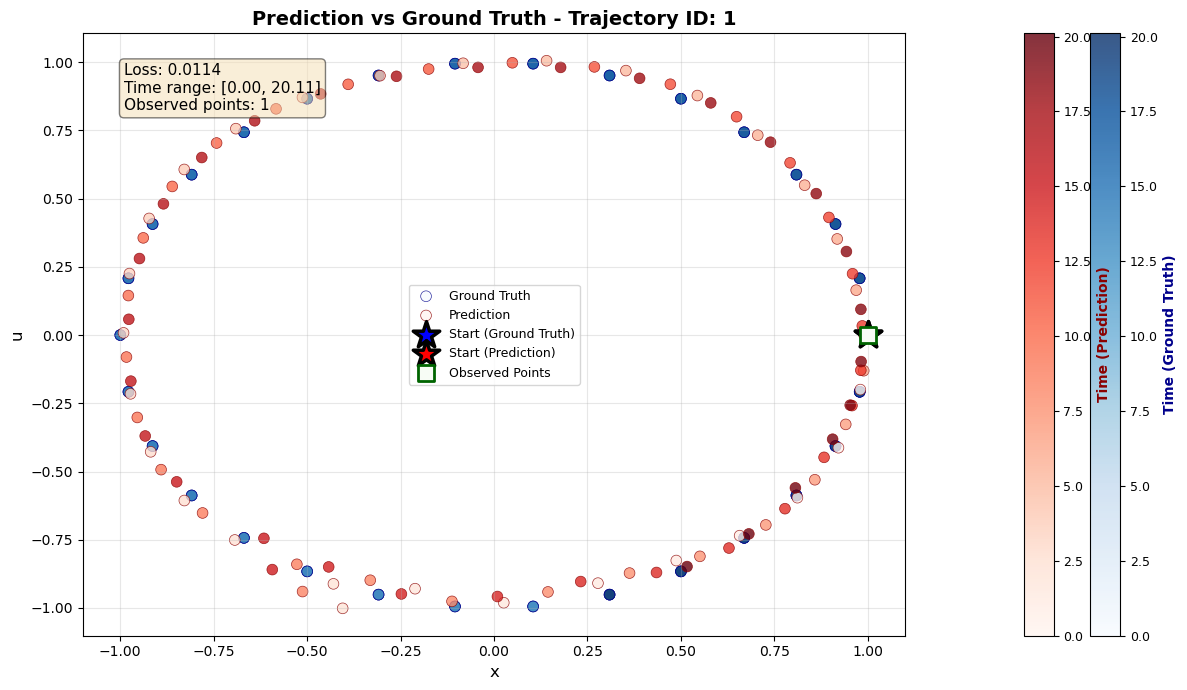

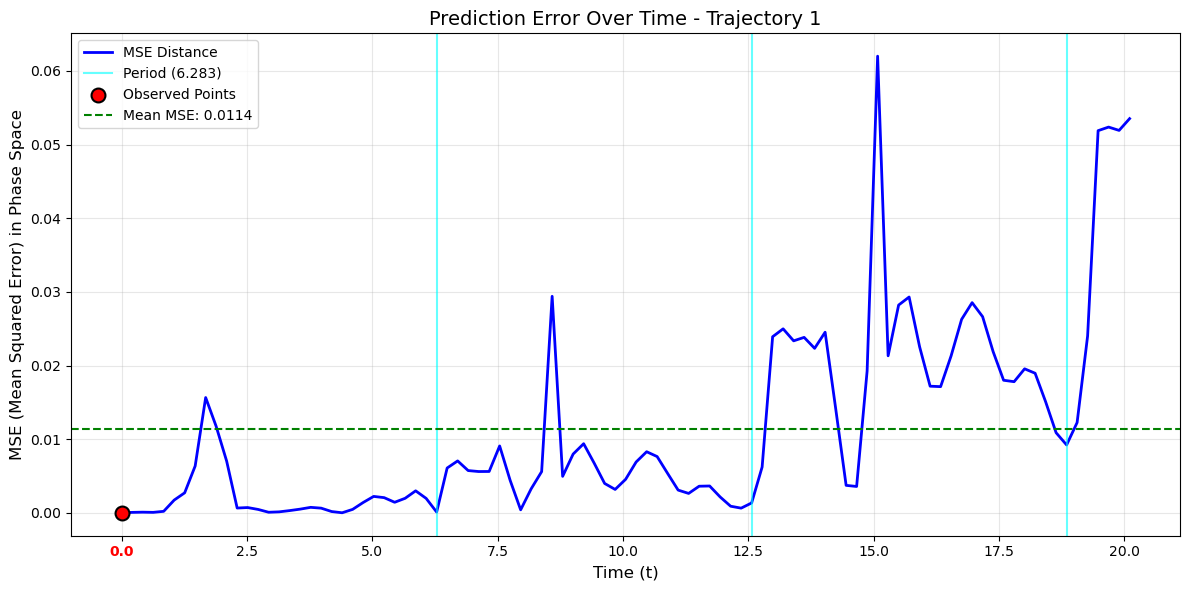

In [36]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_test_traj, test_df=test_df_test_traj, trajectory_id=1, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

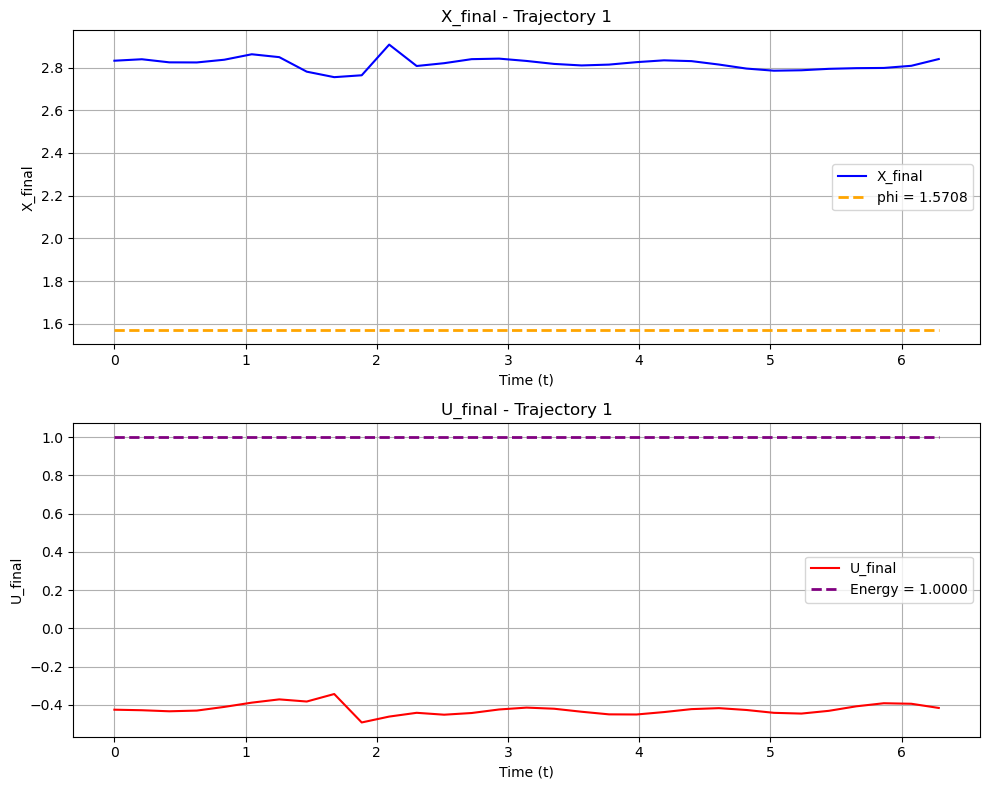

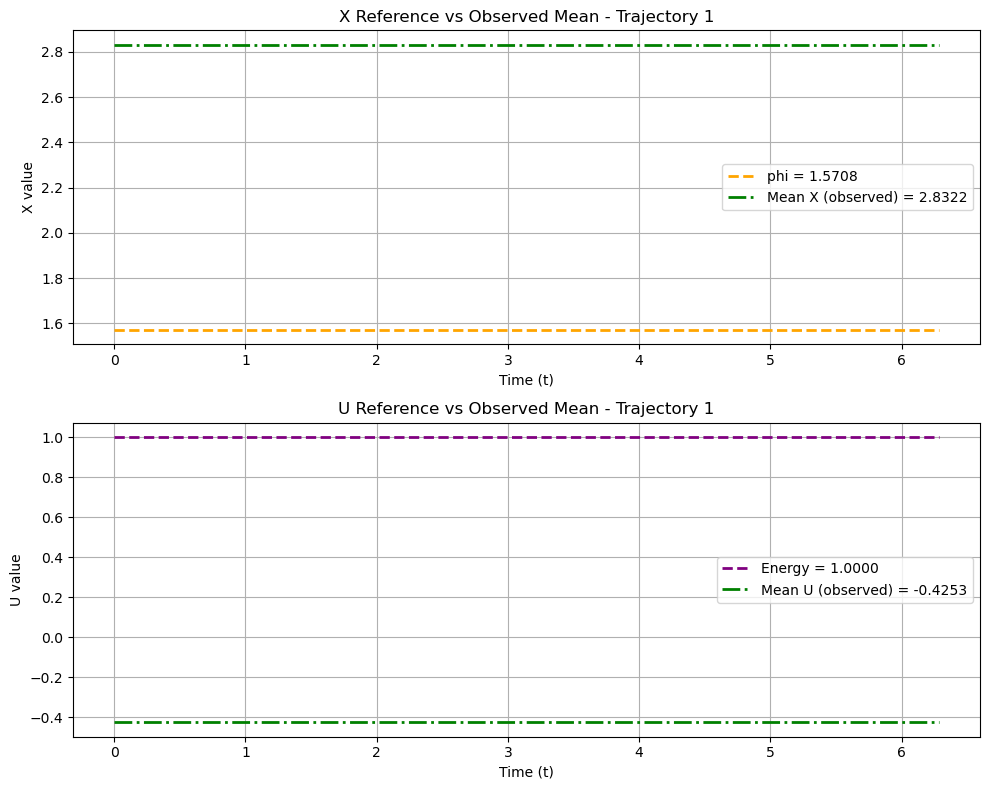

In [37]:

plot_transformed_trajectory(
    test_id_df_test_traj_added, 
    test_df_test_traj, 
    trajectory_id=1,  
    get_data_from_trajectory_id_function=get_data_from_trajectory_id, mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=True,
    point_indexes_observed=point_indexes_observed)




=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8


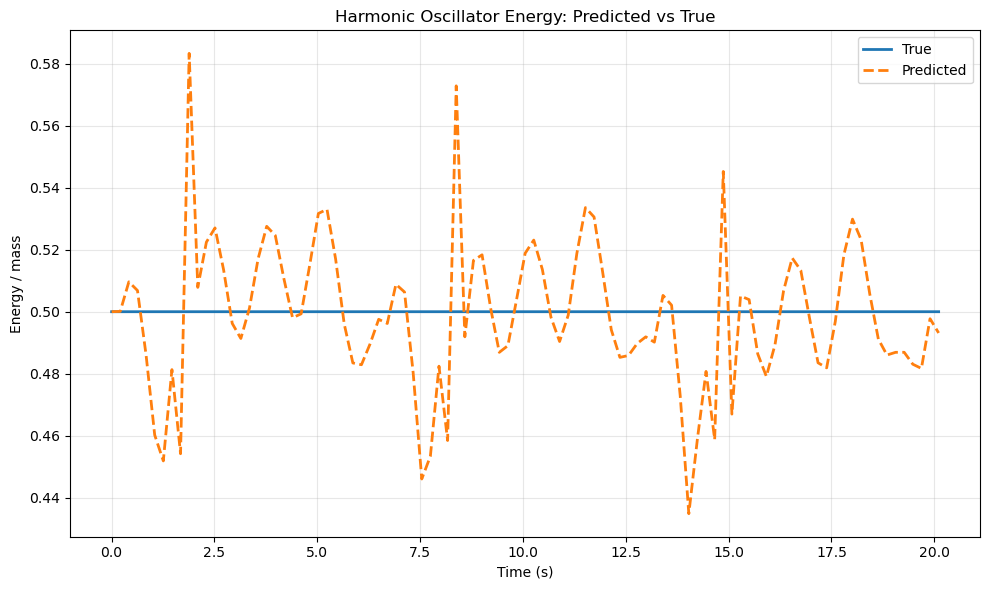

In [ ]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
test_id_df=test_id_df_test_traj_added, 
test_df=test_df_test_traj, 
trajectory_id=1, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
max_t_training=max_t_training, 
efficiently=True, 
threshold=1.0, 
search_range_lower_pct=0.5, 
search_range_upper_pct=0.6,
length=1.0, k=1, mass=1, g=3.0, 
verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 11
inverse_net calls: 612
Total forward passes: 623
Coverage: 100.0%
Observed time points: [0.]


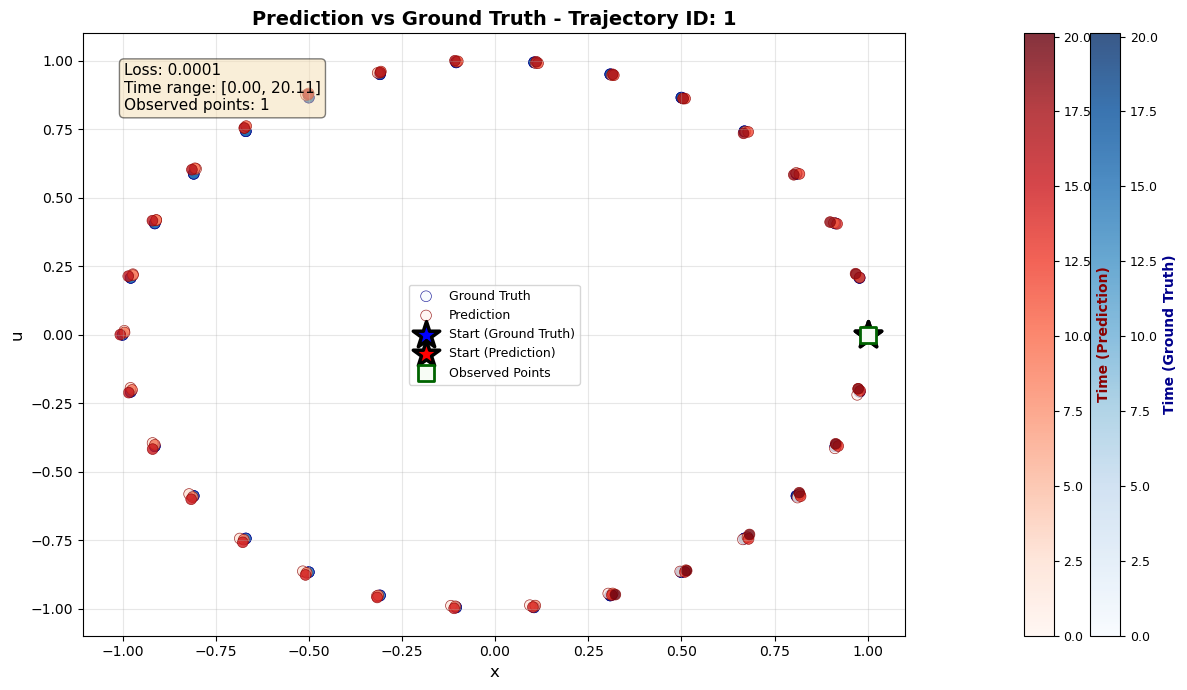

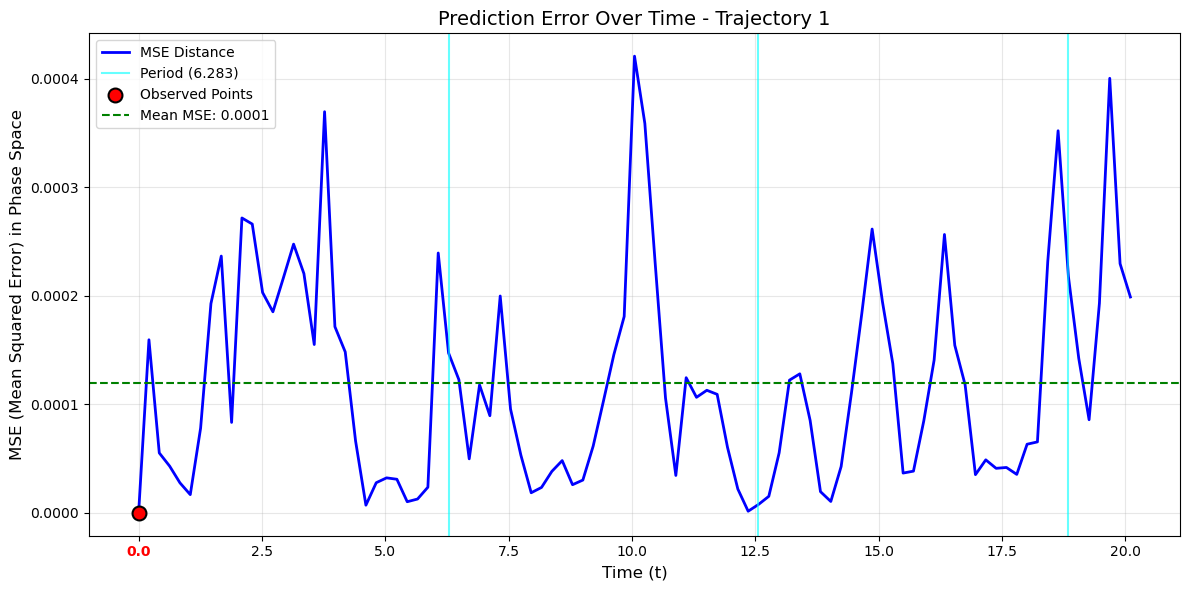

In [27]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_test_traj_added, 
test_df=test_df_test_traj, 
trajectory_id=1, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=None, 
show_zeroings=None, 
show_period=True, 
period=period, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 11
inverse_net calls: 612
Total forward passes: 623
Coverage: 100.0%


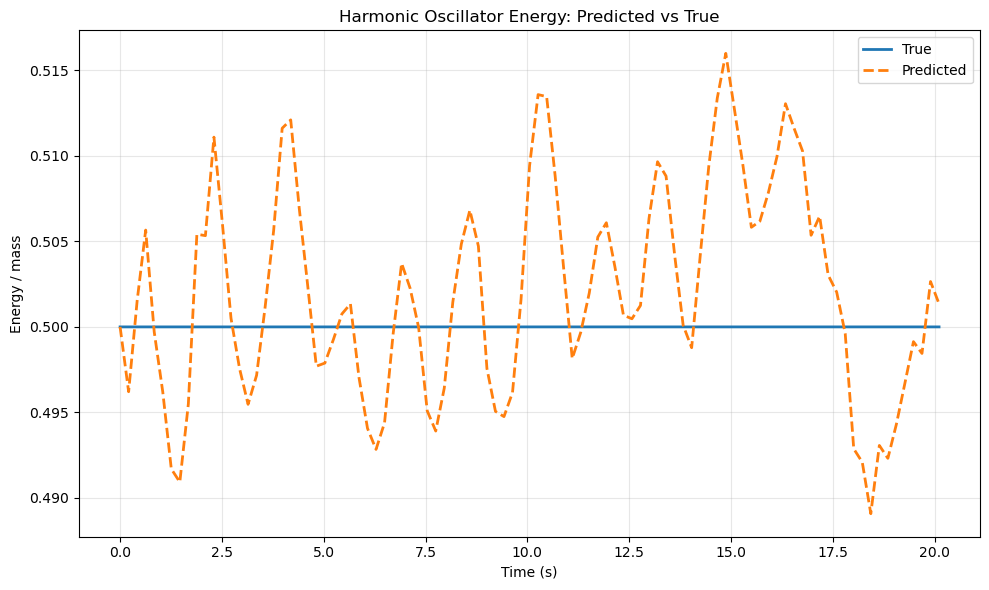

In [30]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
test_id_df=test_id_df_test_traj_added, 
test_df=test_df_test_traj, 
trajectory_id=1, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
max_t_training=max_t_training, 
efficiently=False, 
method = "gaussian_mixture_simple",
threshold=1.0, 
dt=dt,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=2,
search_range_lower_pct=0.1, 
search_range_upper_pct=0.33924736848369563, 
length=1.0, k=1, mass=1, g=3.0, 
verbose=True)

In [ ]:
from scipy import stats

In [ ]:

trent_score_inv_dict = {}
p_score_inv_dict = {}

for traj_id in test_id_df_low_samples['trajectory_id']:
    test_trajectory_data = get_data_from_trajectory_id(test_id_df_low_samples, test_df_low_samples, traj_id)
    x = torch.as_tensor(test_trajectory_data['x'].to_numpy(dtype=np.float32), device=device)
    u = torch.as_tensor(test_trajectory_data['u'].to_numpy(dtype=np.float32), device=device)
    t = torch.as_tensor(test_trajectory_data['t'].to_numpy(dtype=np.float32), device=device)
    obs_idx = 0
    Q, P, _ = mapping_net(x[obs_idx], u[obs_idx], t[obs_idx])
    Q_full = torch.full_like(t, fill_value=Q.item())
    P_full = torch.full_like(t, fill_value=P.item())
    x_pred, u_pred, _ = inverse_net(Q_full, P_full, t)
    t_last_full = torch.full_like(t, fill_value=t[-1].item())
    Q_plus, P_plus, _ = mapping_net(x_pred, u_pred, t_last_full)
    t__obs_pred_relative = t_last_full-t
    x_obs_pred , u_obs_pred, _ = inverse_net(Q_plus, P_plus, t__obs_pred_relative)
    inversion_loss_per_time = torch.abs(x_obs_pred - x[0])+torch.abs(u_obs_pred - u[0])
    prediction_loss_per_time = torch.abs(x_pred - x)+torch.abs(u_pred - u)
    t_np = t.detach().cpu().numpy()
    inv_loss_np = inversion_loss_per_time.detach().cpu().numpy()
    pred_loss_np = prediction_loss_per_time.detach().cpu().numpy()

    d_inv = np.diff(inv_loss_np)
    d_pred = np.diff(pred_loss_np)



    trend_score_inv, p_value = stats.spearmanr(d_inv, d_pred)


    trent_score_inv_dict[traj_id] = trend_score_inv
    p_score_inv_dict[traj_id] = p_value


In [146]:

def plot_dicts_with_mean(dict1, dict2):
    """
    Plots two dictionaries with shared keys and adds their mean values as horizontal lines.
    """
    # 1. Sort keys to ensure the x-axis is ordered
    keys = sorted(dict1.keys())
    
    # 2. Extract values based on the sorted keys order
    values1 = [dict1[k] for k in keys]
    values2 = [dict2[k] for k in keys]
    
    # 3. Calculate Means
    mean1 = np.mean(values1)
    mean2 = np.mean(values2)
    
    print(f"Mean spearmanr score: {mean1:.4f}")
    print(f"Mean p value: {mean2:.4f}")
    
    # 4. Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the actual data
    plt.plot(keys, values1, 'o-', label='spearmanr score between prediction loss and inversion loss', color='blue', alpha=0.7)
    plt.plot(keys, values2, 's-', label='p value between these two', color='red', alpha=0.7)
    
    # Plot the mean lines
    plt.axhline(y=mean1, color='blue', linestyle='--', alpha=0.5, label=f'Mean spearmanr score ({mean1:.2f})')
    plt.axhline(y=mean2, color='red', linestyle='--', alpha=0.5, label=f'Mean p value  ({mean2:.2f})')
    
    # 5. Formatting
    plt.xlabel('Trajectory ids')
    plt.ylabel('spearmanr score')
    plt.title('spearmanr scores of different trajectory ids in test set')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Mean spearmanr score: 0.2139
Mean p value: 0.3656


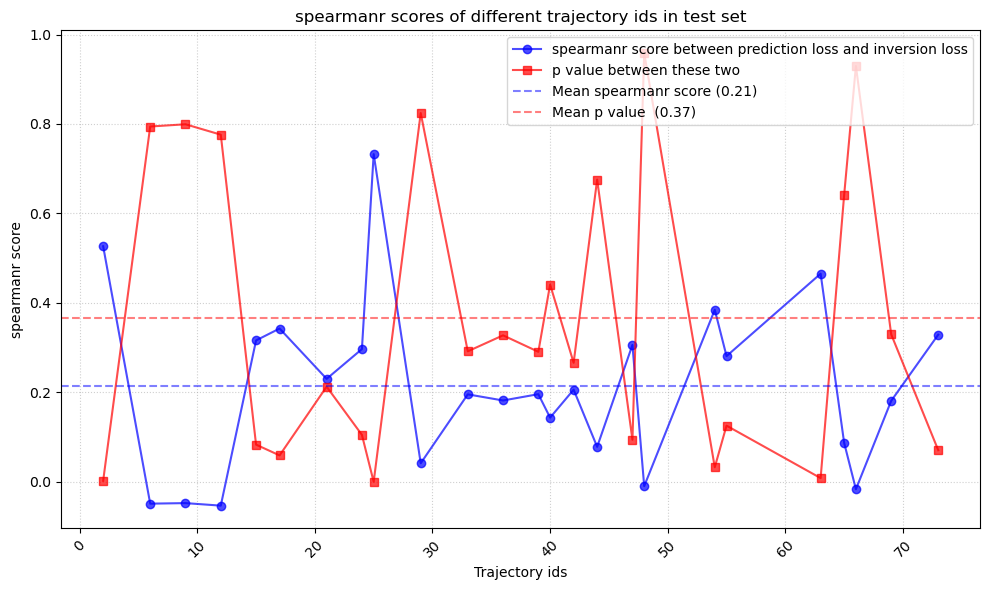

In [147]:

plot_dicts_with_mean(trent_score_inv_dict, p_score_inv_dict)

/tmp/ipykernel_6944/629813452.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


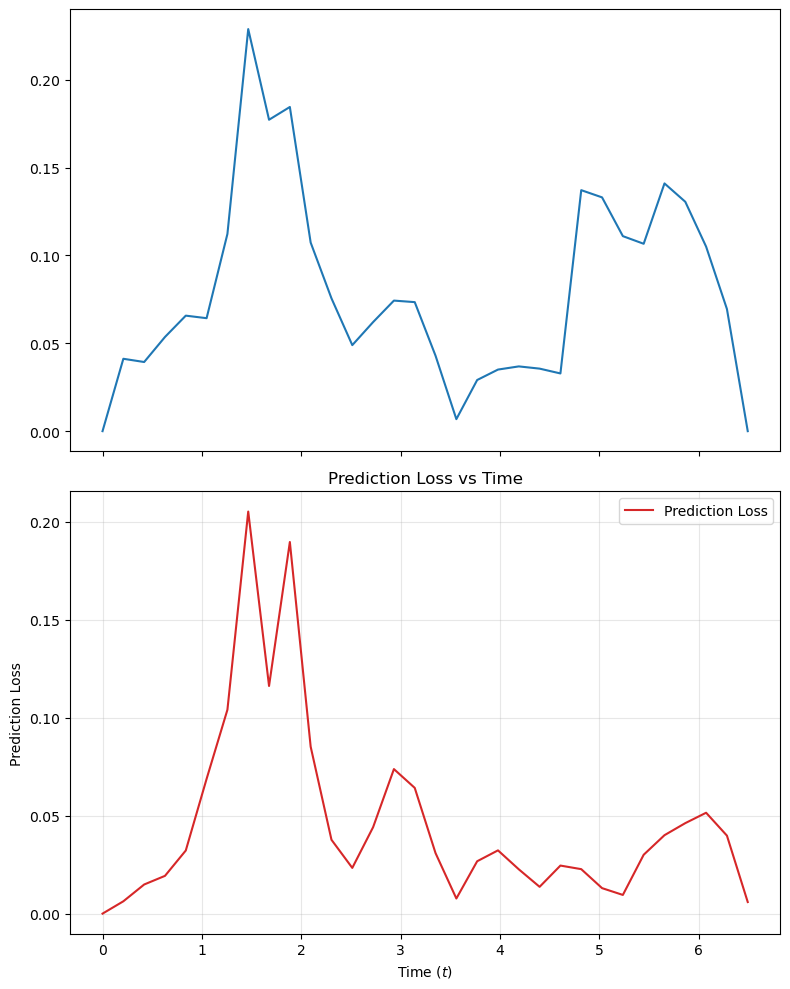

In [143]:


test_trajectory_data = get_data_from_trajectory_id(test_id_df_low_samples, test_df_low_samples, 25)
x = torch.as_tensor(test_trajectory_data['x'].to_numpy(dtype=np.float32), device=device)
u = torch.as_tensor(test_trajectory_data['u'].to_numpy(dtype=np.float32), device=device)
t = torch.as_tensor(test_trajectory_data['t'].to_numpy(dtype=np.float32), device=device)
obs_idx = 0
Q, P, _ = mapping_net(x[obs_idx], u[obs_idx], t[obs_idx])
Q_full = torch.full_like(t, fill_value=Q.item())
P_full = torch.full_like(t, fill_value=P.item())
x_pred, u_pred, _ = inverse_net(Q_full, P_full, t)
t_last_full = torch.full_like(t, fill_value=t[-1].item())
Q_plus, P_plus, _ = mapping_net(x_pred, u_pred, t_last_full)
t__obs_pred_relative = t_last_full-t
x_obs_pred , u_obs_pred, _ = inverse_net(Q_plus, P_plus, t__obs_pred_relative)
inversion_loss_per_time = torch.abs(x_obs_pred - x[0])+torch.abs(u_obs_pred - u[0])
prediction_loss_per_time = torch.abs(x_pred - x)+torch.abs(u_pred - u)
t_np = t.detach().cpu().numpy()
inv_loss_np = inversion_loss_per_time.detach().cpu().numpy()
pred_loss_np = prediction_loss_per_time.detach().cpu().numpy()

fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# 3. Plot Inversion Loss on the first axis (top)
axs[0].plot(t_np, inv_loss_np, label='inv_loss_np', color='tab:blue')
plt.title('Sum of Standard Deviations vs Time')
plt.xlabel('Time (t)')
plt.ylabel('Sum of Std Dev (x_pred + u_pred)')
plt.grid(True, alpha=0.3)
plt.legend()

# 4. Plot Prediction Loss on the second axis (bottom)
axs[1].plot(t_np, pred_loss_np, label='Prediction Loss', color='tab:red')
axs[1].set_xlabel('Time ($t$)')
axs[1].set_ylabel('Prediction Loss')
axs[1].set_title('Prediction Loss vs Time')
axs[1].grid(True)
axs[1].legend()

# 5. Adjust layout to prevent overlap
plt.tight_layout()


plt.show()
